## Import Library

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import math
import pickle

from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error



## Define the functions to be used 

In [7]:
from statistics import stdev

def Average(data):
    return sum(data) / len(data)

def normalize_series(data, mean, std):
    data = data - mean
    data = data / std
    return data

def inverse_normalize_series(data, mean, std):
    data = data * std
    data = data + mean
    return data

In [8]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [9]:
def plot_graphs(history, metric, model):
    plt.plot(history[metric])
    plt.plot(history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of {model}")
    plt.legend([metric, f'val_{metric}'])
    plt.show()

# Dataset

## Read Dataset

In [10]:
dataset = pd.read_excel('./dataset21Apr-21Jun2022.xlsx')
dataset = dataset[['date', 'pm2p5']]

In [11]:
dataset.describe()

pm2p5
count  1488.000000
mean     30.823925
std      76.192929
min      -3.000000
25%      14.000000
50%      22.000000
75%      33.000000
max     985.000000

Text(0.5, 1.0, 'Raw Data of Hourly Data PM2.5 from Apr 21st - Jun 21st 2022')

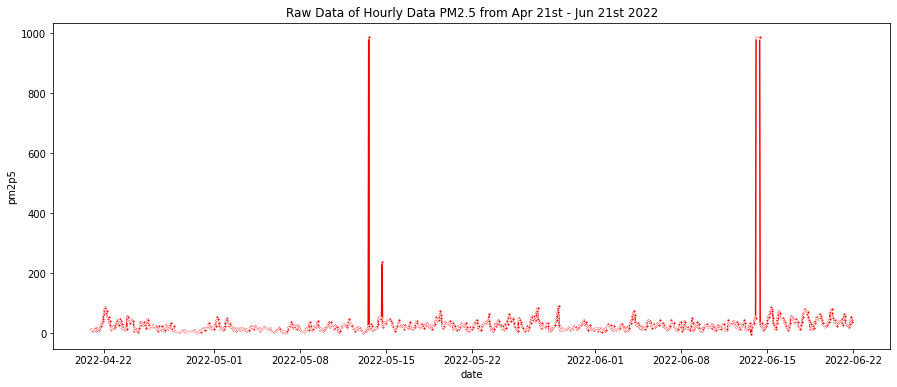

In [12]:
plt.subplots(figsize = (15,6)) 
sns.lineplot(x="date", y="pm2p5",
             data=dataset, marker='.', color='red')
plt.title("Raw Data of Hourly Data PM2.5 from Apr 21st - Jun 21st 2022")

## Remove negative values and above 200

In [13]:
for i in range(len(dataset)):
    if dataset['pm2p5'][i] < 0 or dataset['pm2p5'][i] > 200:
        dataset['pm2p5'][i] = np.nan

c:\Python\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
dataset.describe()

pm2p5
count  1476.000000
mean     24.911247
std      15.220311
min       1.000000
25%      14.000000
50%      21.000000
75%      33.000000
max      91.000000

In [15]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1488 non-null   datetime64[ns]
 1   pm2p5   1476 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.4 KB
None


<AxesSubplot:>

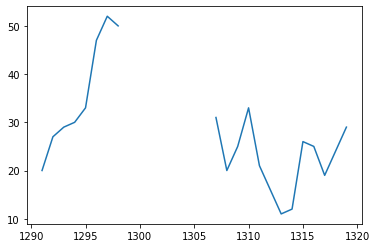

In [16]:
dataset['pm2p5'][1290:1320].plot()

## Fill empty data with interpolate method

In [17]:
dataset['pm2p5'] = dataset['pm2p5'].interpolate(option='spline')

In [18]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1488 non-null   datetime64[ns]
 1   pm2p5   1488 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.4 KB
None


<AxesSubplot:>

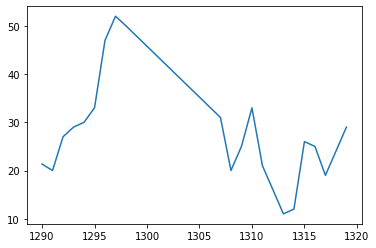

In [19]:
dataset['pm2p5'][1290:1320].plot()

Text(0.5, 1.0, 'Hourly Data PM2.5 from Apr 21st - Jun 21st 2022')

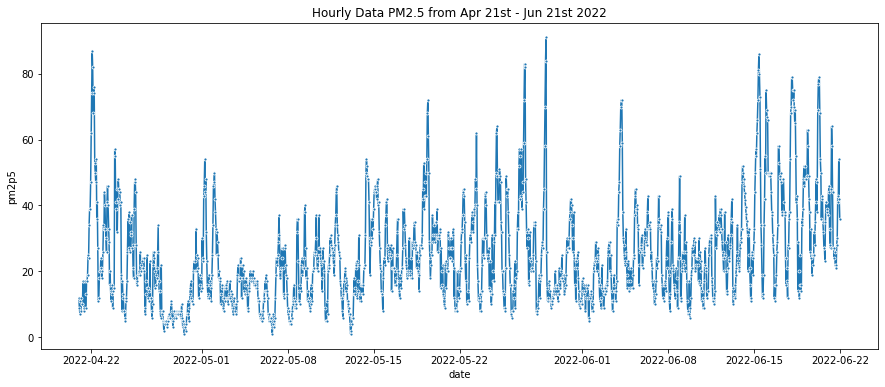

In [20]:
from turtle import color


plt.subplots(figsize = (15,6))
sns.lineplot(x="date", y="pm2p5",
             data=dataset, marker='.')
plt.title("Hourly Data PM2.5 from Apr 21st - Jun 21st 2022")

In [21]:
dataset.describe()

pm2p5
count  1488.000000
mean     24.992608
std      15.206912
min       1.000000
25%      14.000000
50%      22.000000
75%      33.000000
max      91.000000

## Split data to validation and testing

split data with proportion 70% for training data, 20% for validation data and 10% for testing

In [22]:
n_lookback = 24  # length of input sequences (lookback period)
n_forecast = 24  # length of output sequences (forecast period)

In [23]:
SPLIT_TIME_TRAIN_REM = int(math.floor(0.7*((len(dataset))/24)) * 24) 
SPLIT_TIME_TRAIN_REM

1032

In [24]:
data_train = dataset[:SPLIT_TIME_TRAIN_REM]['pm2p5']
data_train = pd.DataFrame(data_train)
data_train.index = dataset[:SPLIT_TIME_TRAIN_REM]['date']

data_rem = dataset[SPLIT_TIME_TRAIN_REM:]['pm2p5']
data_rem = pd.DataFrame(data_rem)
data_rem.index = dataset[SPLIT_TIME_TRAIN_REM:]['date']

In [25]:
SPLIT_TIME_VAL_TEST = int(math.floor(0.87*((len(data_rem))/24)) * 24) 
SPLIT_TIME_VAL_TEST

384

In [26]:
data_val = data_rem[:SPLIT_TIME_VAL_TEST]
data_val = pd.DataFrame(data_val)

data_test = data_rem[SPLIT_TIME_VAL_TEST:]
data_test = pd.DataFrame(data_test)

In [27]:
# % of training set
print(len(data_train)/len(dataset))
print(len(data_val)/len(dataset))
print(len(data_test)/len(dataset))

0.6935483870967742
0.25806451612903225
0.04838709677419355


In [28]:
data_test.head()

pm2p5
date                      
2022-06-19 00:00:00   48.0
2022-06-19 01:00:00   52.0
2022-06-19 02:00:00   46.0
2022-06-19 03:00:00   52.0
2022-06-19 04:00:00   48.0

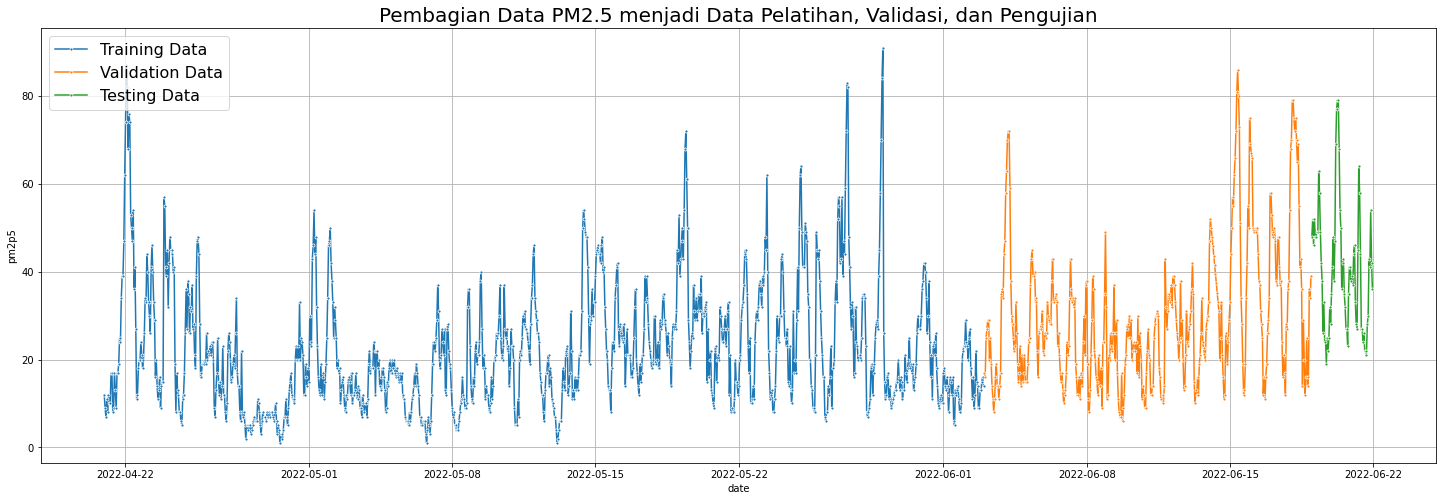

In [29]:
from turtle import color


plt.subplots(figsize = (25,8))
sns.lineplot(x="date", y="pm2p5",
             data=data_train, marker='.', label='Training Data')
sns.lineplot(x="date", y="pm2p5",
             data=data_val, marker='.', label='Validation Data')
sns.lineplot(x="date", y="pm2p5",
             data=data_test, marker='.', label='Testing Data')
plt.title("Pembagian Data PM2.5 menjadi Data Pelatihan, Validasi, dan Pengujian", fontsize = 20)
plt.legend(loc='upper left', prop={'size': 16})
plt.grid()

In [30]:
pm2p5 = dataset["pm2p5"].values.reshape(-1, 1)

pm2p5_train = data_train.values.reshape(-1, 1)

pm2p5_val = data_val.values.reshape(-1, 1)

pm2p5_test = data_test.values.reshape(-1, 1)

print(pm2p5_train.shape);print(pm2p5_val.shape);print(pm2p5_test.shape)

(1032, 1)
(384, 1)
(72, 1)


In [31]:
x_train = []
y_train = []

for i in range(n_lookback, len(pm2p5_train) - n_forecast + 1):
    x_train.append(pm2p5_train[i - n_lookback: i])
    y_train.append(pm2p5_train[i: i + n_forecast])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(985, 24, 1)
(985, 24, 1)


In [32]:
print(x_train[0]);print(y_train[0])

[[12.]
 [ 9.]
 [ 7.]
 [11.]
 [ 8.]
 [12.]
 [10.]
 [10.]
 [17.]
 [17.]
 [ 8.]
 [ 9.]
 [17.]
 [13.]
 [ 9.]
 [17.]
 [17.]
 [19.]
 [25.]
 [24.]
 [34.]
 [39.]
 [39.]
 [47.]]
[[62.]
 [74.]
 [87.]
 [82.]
 [68.]
 [76.]
 [74.]
 [53.]
 [50.]
 [47.]
 [54.]
 [36.]
 [41.]
 [27.]
 [11.]
 [12.]
 [18.]
 [20.]
 [20.]
 [24.]
 [21.]
 [18.]
 [20.]
 [26.]]


In [33]:
x_val = []
y_val = []

for i in range(n_lookback, len(pm2p5_val) - n_forecast + 1):
    x_val.append(pm2p5_val[i - n_lookback: i])
    y_val.append(pm2p5_val[i: i + n_forecast])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(337, 24, 1)
(337, 24, 1)


In [34]:
print(x_val[-1]);print(y_val[-1])

[[58.]
 [53.]
 [48.]
 [49.]
 [50.]
 [47.]
 [38.]
 [37.]
 [48.]
 [48.]
 [41.]
 [37.]
 [38.]
 [24.]
 [16.]
 [21.]
 [17.]
 [12.]
 [28.]
 [27.]
 [36.]
 [38.]
 [54.]
 [68.]]
[[70.]
 [79.]
 [79.]
 [75.]
 [72.]
 [75.]
 [70.]
 [65.]
 [69.]
 [55.]
 [41.]
 [43.]
 [36.]
 [14.]
 [29.]
 [20.]
 [12.]
 [16.]
 [25.]
 [14.]
 [16.]
 [36.]
 [34.]
 [39.]]


## Scaling / Normalize Data

In [35]:
pm2p5_train_scaled = normalize_series(pm2p5_train, Average(pm2p5_train), stdev(pm2p5_train.flatten()))

pm2p5_val_scaled = normalize_series(pm2p5_val, Average(pm2p5_val), stdev(pm2p5_val.flatten()))

pm2p5_test_scaled = normalize_series(pm2p5_test, Average(pm2p5_test), stdev(pm2p5_test.flatten()))

## Set feature and label period

In [36]:
x_train_scaled = []
y_train_scaled = []

for i in range(n_lookback, len(pm2p5_train_scaled) - n_forecast + 1):
    x_train_scaled.append(pm2p5_train_scaled[i - n_lookback: i])
    y_train_scaled.append(pm2p5_train_scaled[i: i + n_forecast])

x_train_scaled = np.array(x_train_scaled)
y_train_scaled = np.array(y_train_scaled)
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(985, 24, 1)
(985, 24, 1)


In [37]:
x_val_scaled = []
y_val_scaled = []

for i in range(n_lookback, len(pm2p5_val_scaled) - n_forecast + 1):
    x_val_scaled.append(pm2p5_val_scaled[i - n_lookback: i])
    y_val_scaled.append(pm2p5_val_scaled[i: i + n_forecast])

x_val_scaled = np.array(x_val_scaled)
y_val_scaled = np.array(y_val_scaled)
print(x_val_scaled.shape)
print(y_val_scaled.shape)

(337, 24, 1)
(337, 24, 1)


# Vanilla GRU

## Read Model

In [38]:
modelVanillaGRU = tf.keras.models.load_model('./Models/UnivariateForecast_VanillaGRU-Model.h5')

In [39]:
y_val_pred = modelVanillaGRU.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 0s 2ms/step
(337, 24)


In [40]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = modelVanillaGRU.evaluate(x_train_scaled, y_train_scaled, batch_size=8)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = modelVanillaGRU.evaluate(x_val_scaled, y_val_scaled, batch_size=8)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
124/124 [==============================] - 0s 2ms/step - loss: 0.3034 - mse: 0.7421
train loss, train mse: [0.3034 0.7421]
Evaluate on val data
43/43 [==============================] - 0s 2ms/step - loss: 0.3131 - mse: 0.7594
val loss, val mse: [0.3131 0.7594]


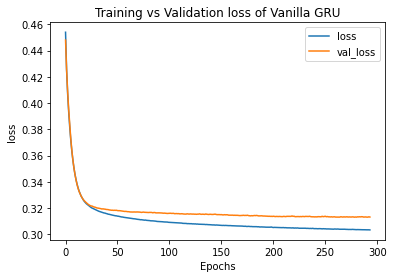

294


In [41]:
with open('./Models/historyVanillaGRU', "rb") as file_pi:
    load_historyVanillaGRU = pickle.load(file_pi)

plot_graphs(load_historyVanillaGRU, "loss", "Vanilla GRU")
print(len(load_historyVanillaGRU['loss']))

## Prediction

### Prediction with training data

In [42]:
forecast_train_data = model_forecast(modelVanillaGRU, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1009/1009 [==============================] - 2s 2ms/step
(1009, 24)
(1008,)
1008


In [43]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([39.76514621, 45.63250156, 51.99130054, 58.26723667, 60.70532794])

In [44]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [45]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  39.765146
1    2022-04-22 01:00:00    74.0  45.632502
2    2022-04-22 02:00:00    87.0  51.991301
3    2022-04-22 03:00:00    82.0  58.267237
4    2022-04-22 04:00:00    68.0  60.705328
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  11.431830
1004 2022-06-02 20:00:00    13.0  14.238889
1005 2022-06-02 21:00:00    15.0  15.979891
1006 2022-06-02 22:00:00    16.0  16.144758
1007 2022-06-02 23:00:00    14.0  16.105514

[1008 rows x 3 columns]

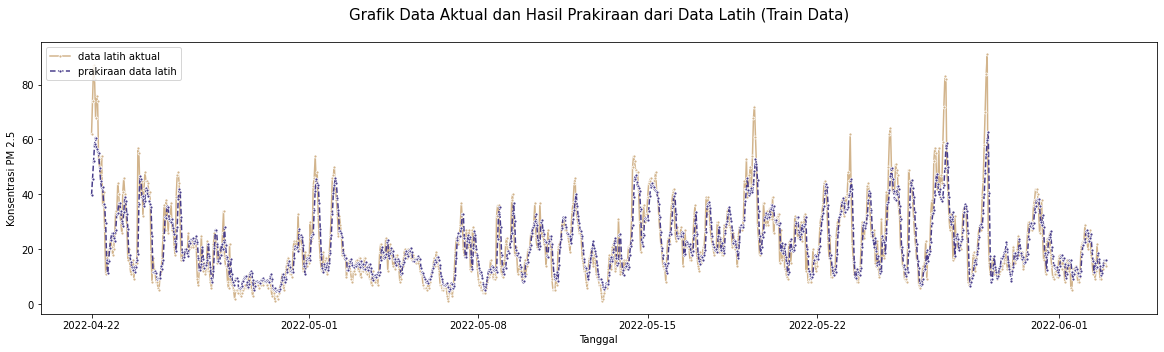

In [46]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [47]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  7.13
MAE:  5.02
MAPE:  0.2455


### Prediction with validation data

In [48]:
forecast_val_data = model_forecast(modelVanillaGRU, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 0s 1ms/step
(361, 24)
(360,)
360


In [49]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([39.85532475, 45.22108269, 52.28936577, 56.63602829, 59.26895332])

In [50]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [51]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  39.855325
1   2022-06-04 01:00:00    58.0  45.221083
2   2022-06-04 02:00:00    63.0  52.289366
3   2022-06-04 03:00:00    70.0  56.636028
4   2022-06-04 04:00:00    72.0  59.268953
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  24.148721
356 2022-06-18 20:00:00    16.0  22.749571
357 2022-06-18 21:00:00    36.0  21.421189
358 2022-06-18 22:00:00    34.0  32.036023
359 2022-06-18 23:00:00    39.0  37.519328

[360 rows x 3 columns]

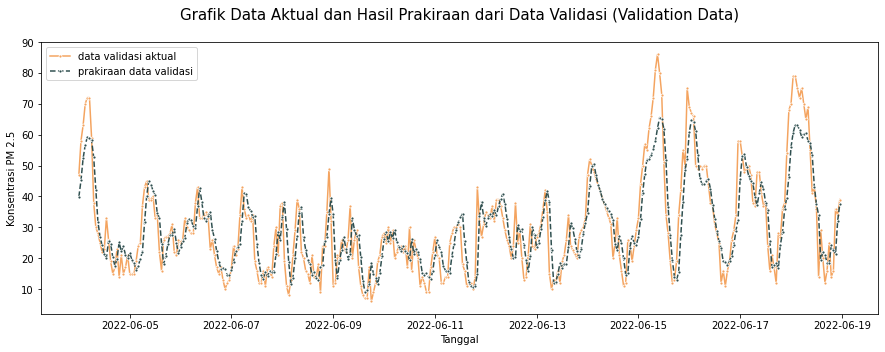

In [52]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [53]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  8.09
MAE:  6.23
MAPE:  0.2302


### Prediction with test data

In [54]:
forecast_test_data = model_forecast(modelVanillaGRU, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 1ms/step
(49, 24)
(48,)
48


In [55]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([35.57669152, 40.00737764, 47.54413546, 43.31321777, 46.08134593])

In [56]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [57]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  35.576692
1  2022-06-20 01:00:00    48.0  40.007378
2  2022-06-20 02:00:00    38.0  47.544135
3  2022-06-20 03:00:00    47.0  43.313218
4  2022-06-20 04:00:00    69.0  46.081346
5  2022-06-20 05:00:00    77.0  56.511790
6  2022-06-20 06:00:00    79.0  65.648681
7  2022-06-20 07:00:00    79.0  69.197947
8  2022-06-20 08:00:00    68.0  67.993756
9  2022-06-20 09:00:00    54.0  64.279691
10 2022-06-20 10:00:00    50.0  56.023274
11 2022-06-20 11:00:00    36.0  50.127540
12 2022-06-20 12:00:00    42.0  39.426889
13 2022-06-20 13:00:00    43.0  39.204974
14 2022-06-20 14:00:00    35.0  39.628363
15 2022-06-20 15:00:00    32.0  35.895192
16 2022-06-20 16:00:00    27.0  30.674130
17 2022-06-20 17:00:00    27.0  26.575696
18 2022-06-20 18:00:00    23.0  25.531850
19 2022-06-20 19:00:00    35.0  24.325961
20 2022-06-20 20:00:00    41.0  31.793454
21 2022-06-20 21:00:00    41.0  40.048606
22 2022-06-20 22:00:00    38.0  44.462771
23 2022-06-20 23:00:00    39.0  42.513035
24 2022-06-21 00:00:00    37.0  41.967924
25 2022-06-21 01:00:00    44.0  40.988616
26 2022-06-21 02:00:00    46.0  46.754301
27 2022-06-21 03:00:00    33.0  49.289279
28 2022-06-21 04:00:00    28.0  39.053460
29 2022-06-21 05:00:00    27.0  30.142841
30 2022-06-21 06:00:00    45.0  25.113074
31 2022-06-21 07:00:00    64.0  35.750992
32 2022-06-21 08:00:00    58.0  52.025517
33 2022-06-21 09:00:00    44.0  59.071544
34 2022-06-21 10:00:00    27.0  51.785818
35 2022-06-21 11:00:00    27.0  36.494441
36 2022-06-21 12:00:00    24.0  28.096365
37 2022-06-21 13:00:00    26.0  24.566332
38 2022-06-21 14:00:00    22.0  26.508340
39 2022-06-21 15:00:00    22.0  24.657868
40 2022-06-21 16:00:00    21.0  23.365870
41 2022-06-21 17:00:00    28.0  21.319941
42 2022-06-21 18:00:00    30.0  25.786691
43 2022-06-21 19:00:00    43.0  30.677879
44 2022-06-21 20:00:00    41.0  40.940422
45 2022-06-21 21:00:00    54.0  45.524809
46 2022-06-21 22:00:00    42.0  52.384150
47 2022-06-21 23:00:00    36.0  48.540551

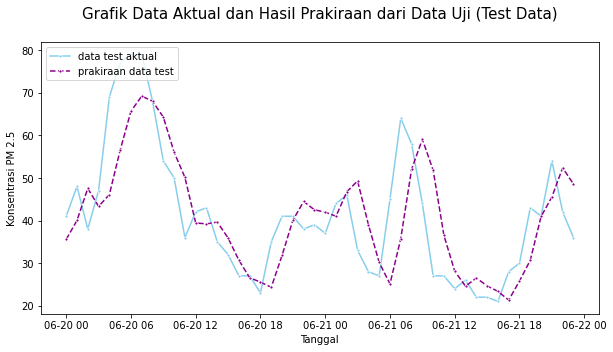

In [58]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [59]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  10.49
MAE:  8.09
MAPE:  0.2024


## Summary Eval Metric

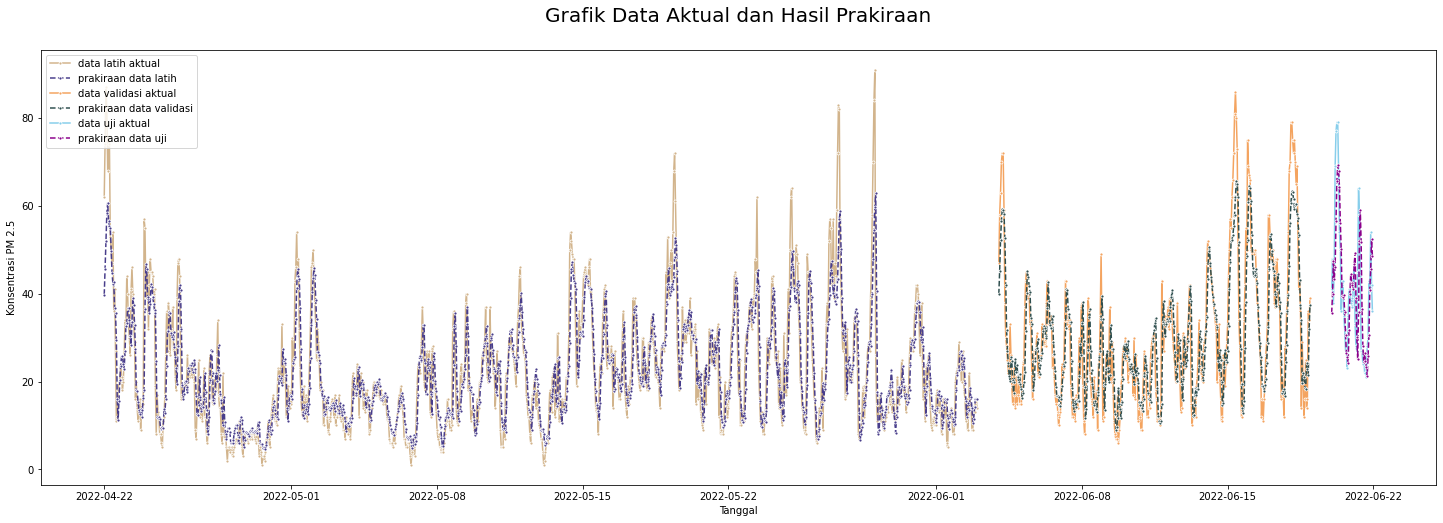

In [60]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [61]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  7.13
MAE:  5.02
MAPE:  0.2455
Forecast Val accuracy
RMSE:  8.09
MAE:  6.23
MAPE:  0.2302
Forecast Test accuracy
RMSE:  10.49
MAE:  8.09
MAPE:  0.2024


# 2Stacked GRU

## Read Model

In [62]:
model2StackedGRU = tf.keras.models.load_model('./Models/UnivariateForecast_2StackedGRU-Model.h5')

In [63]:
y_val_pred = model2StackedGRU.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 0s 2ms/step
(337, 24)


In [64]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = model2StackedGRU.evaluate(x_train_scaled, y_train_scaled, batch_size=64)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = model2StackedGRU.evaluate(x_val_scaled, y_val_scaled, batch_size=64)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
16/16 [==============================] - 0s 3ms/step - loss: 0.3247 - mse: 0.7850
train loss, train mse: [0.3247 0.785 ]
Evaluate on val data
6/6 [==============================] - 0s 3ms/step - loss: 0.3262 - mse: 0.7825
val loss, val mse: [0.3262 0.7825]


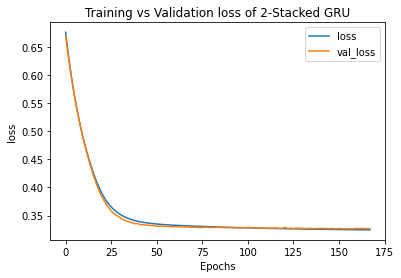

168


In [65]:
with open('./Models/history2StackedGRU', "rb") as file_pi:
    load_history2StackedGRU = pickle.load(file_pi)

plot_graphs(load_history2StackedGRU, "loss", "2-Stacked GRU")
print(len(load_history2StackedGRU['loss']))

## Prediction

### Prediction with training data

In [66]:
forecast_train_data = model_forecast(model2StackedGRU, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

1009/1009 [==============================] - 2s 2ms/step
(1009, 24)
(1008,)
1008


In [67]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([32.96393104, 37.53734966, 43.29623027, 50.12529178, 55.30689807])

In [68]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [69]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  32.963931
1    2022-04-22 01:00:00    74.0  37.537350
2    2022-04-22 02:00:00    87.0  43.296230
3    2022-04-22 03:00:00    82.0  50.125292
4    2022-04-22 04:00:00    68.0  55.306898
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  15.064826
1004 2022-06-02 20:00:00    13.0  15.164833
1005 2022-06-02 21:00:00    15.0  15.751104
1006 2022-06-02 22:00:00    16.0  16.165710
1007 2022-06-02 23:00:00    14.0  16.904018

[1008 rows x 3 columns]

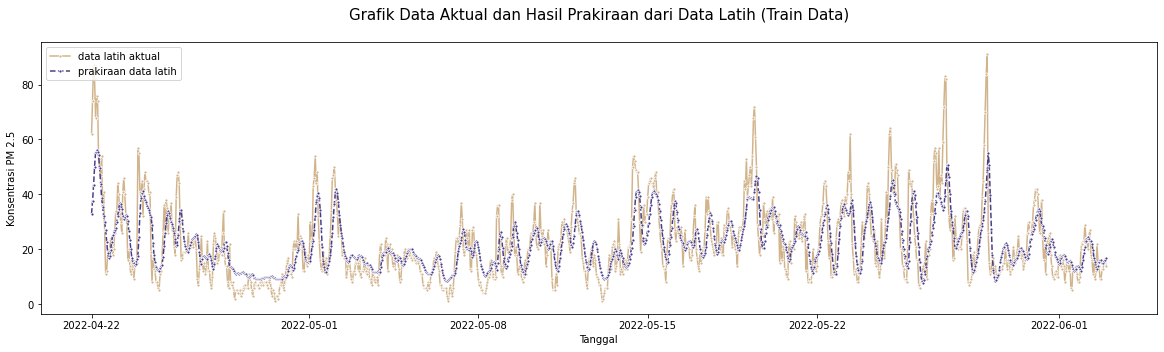

In [70]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [71]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  9.03
MAE:  6.52
MAPE:  0.3055


### Prediction with validation data

In [72]:
forecast_val_data = model_forecast(model2StackedGRU, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 1s 2ms/step
(361, 24)
(360,)
360


In [73]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([34.63916349, 37.98704338, 41.69795609, 45.61141777, 49.16890717])

In [74]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [75]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  34.639163
1   2022-06-04 01:00:00    58.0  37.987043
2   2022-06-04 02:00:00    63.0  41.697956
3   2022-06-04 03:00:00    70.0  45.611418
4   2022-06-04 04:00:00    72.0  49.168907
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  22.577720
356 2022-06-18 20:00:00    16.0  23.449539
357 2022-06-18 21:00:00    36.0  24.662439
358 2022-06-18 22:00:00    34.0  28.099679
359 2022-06-18 23:00:00    39.0  32.047933

[360 rows x 3 columns]

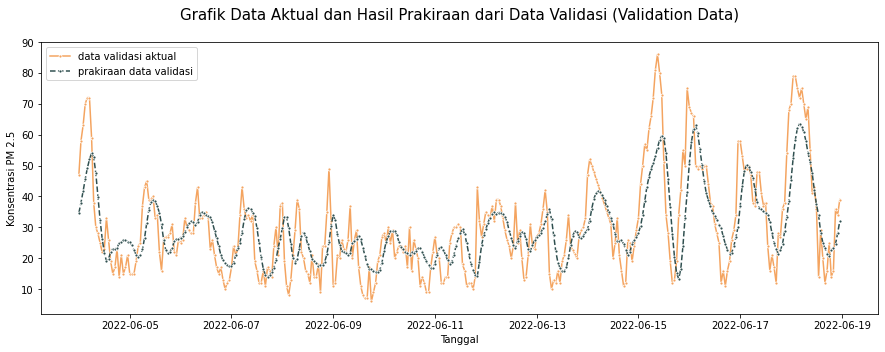

In [76]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [77]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  10.48
MAE:  8.03
MAPE:  0.2867


### Prediction with test data

In [78]:
forecast_test_data = model_forecast(model2StackedGRU, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 2ms/step
(49, 24)
(48,)
48


In [79]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([35.02631511, 37.98023142, 42.0130061 , 43.99046577, 45.7645625 ])

In [80]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [81]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  35.026315
1  2022-06-20 01:00:00    48.0  37.980231
2  2022-06-20 02:00:00    38.0  42.013006
3  2022-06-20 03:00:00    47.0  43.990466
4  2022-06-20 04:00:00    69.0  45.764563
5  2022-06-20 05:00:00    77.0  49.297610
6  2022-06-20 06:00:00    79.0  54.775437
7  2022-06-20 07:00:00    79.0  59.626157
8  2022-06-20 08:00:00    68.0  62.570201
9  2022-06-20 09:00:00    54.0  62.645183
10 2022-06-20 10:00:00    50.0  59.334401
11 2022-06-20 11:00:00    36.0  54.271266
12 2022-06-20 12:00:00    42.0  46.968095
13 2022-06-20 13:00:00    43.0  41.198501
14 2022-06-20 14:00:00    35.0  37.621759
15 2022-06-20 15:00:00    32.0  34.784474
16 2022-06-20 16:00:00    27.0  31.992090
17 2022-06-20 17:00:00    27.0  29.800808
18 2022-06-20 18:00:00    23.0  28.348125
19 2022-06-20 19:00:00    35.0  28.022227
20 2022-06-20 20:00:00    41.0  30.133901
21 2022-06-20 21:00:00    41.0  33.958749
22 2022-06-20 22:00:00    38.0  38.670286
23 2022-06-20 23:00:00    39.0  42.124053
24 2022-06-21 00:00:00    37.0  43.888246
25 2022-06-21 01:00:00    44.0  44.429992
26 2022-06-21 02:00:00    46.0  45.870207
27 2022-06-21 03:00:00    33.0  46.674500
28 2022-06-21 04:00:00    28.0  44.734050
29 2022-06-21 05:00:00    27.0  40.810786
30 2022-06-21 06:00:00    45.0  36.233414
31 2022-06-21 07:00:00    64.0  35.333690
32 2022-06-21 08:00:00    58.0  39.494139
33 2022-06-21 09:00:00    44.0  44.733898
34 2022-06-21 10:00:00    27.0  46.679940
35 2022-06-21 11:00:00    27.0  43.852889
36 2022-06-21 12:00:00    24.0  38.719962
37 2022-06-21 13:00:00    26.0  33.969664
38 2022-06-21 14:00:00    22.0  30.870036
39 2022-06-21 15:00:00    22.0  28.875188
40 2022-06-21 16:00:00    21.0  27.650823
41 2022-06-21 17:00:00    28.0  27.079890
42 2022-06-21 18:00:00    30.0  27.439550
43 2022-06-21 19:00:00    43.0  28.429688
44 2022-06-21 20:00:00    41.0  32.209740
45 2022-06-21 21:00:00    54.0  36.605636
46 2022-06-21 22:00:00    42.0  41.936821
47 2022-06-21 23:00:00    36.0  44.962661

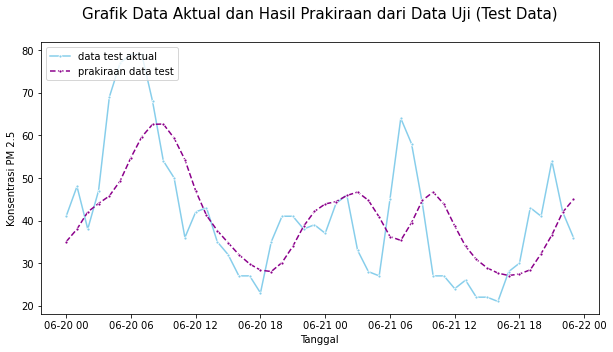

In [82]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [83]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  12.11
MAE:  9.51
MAPE:  0.2352


## Summary Eval Metric

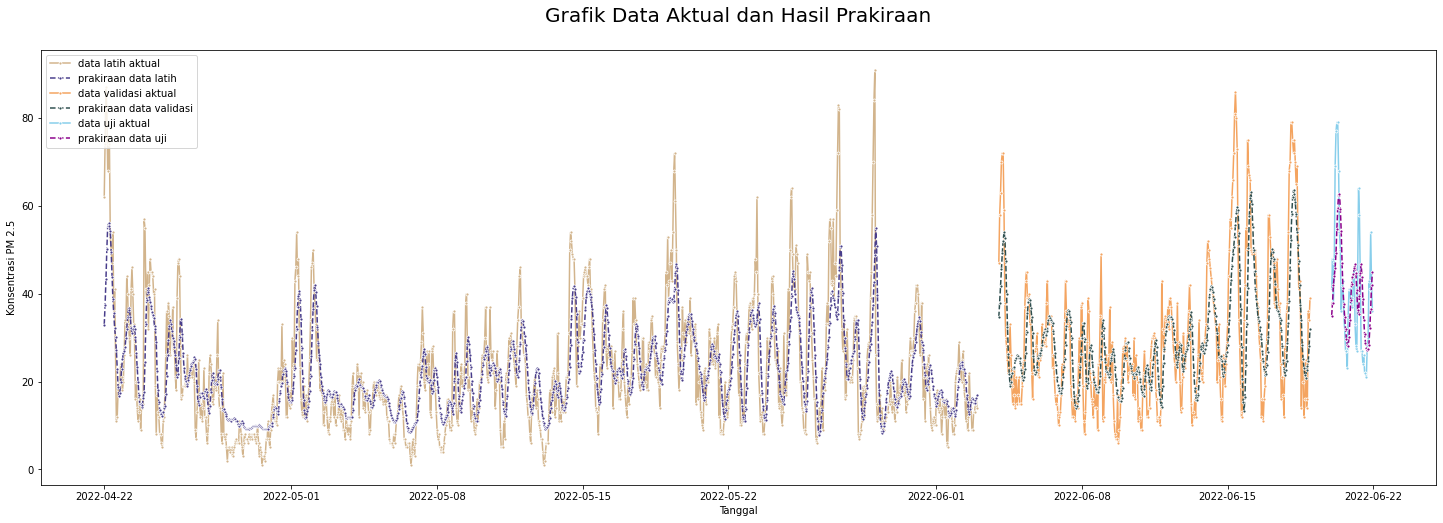

In [84]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [85]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  9.03
MAE:  6.52
MAPE:  0.3055
Forecast Val accuracy
RMSE:  10.48
MAE:  8.03
MAPE:  0.2867
Forecast Test accuracy
RMSE:  12.11
MAE:  9.51
MAPE:  0.2352


# 3Stacked GRU

## Read Model

In [86]:
model3StackedGRU = tf.keras.models.load_model('./Models/UnivariateForecast_3StackedGRU-Model.h5')

In [87]:
y_val_pred = model3StackedGRU.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 0s 3ms/step
(337, 24)


In [88]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = model3StackedGRU.evaluate(x_train_scaled, y_train_scaled, batch_size=64)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = model3StackedGRU.evaluate(x_val_scaled, y_val_scaled, batch_size=64)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
16/16 [==============================] - 0s 3ms/step - loss: 0.3347 - mse: 0.7998
train loss, train mse: [0.3347 0.7998]
Evaluate on val data
6/6 [==============================] - 0s 3ms/step - loss: 0.3347 - mse: 0.7916
val loss, val mse: [0.3347 0.7916]


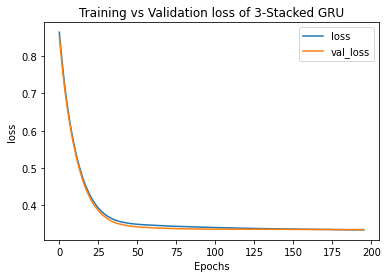

196


In [89]:
with open('./Models/history3StackedGRU', "rb") as file_pi:
    load_history3StackedGRU = pickle.load(file_pi)

plot_graphs(load_history3StackedGRU, "loss", "3-Stacked GRU")
print(len(load_history3StackedGRU['loss']))

## Prediction

### Prediction with training data

In [90]:
forecast_train_data = model_forecast(model3StackedGRU, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

1009/1009 [==============================] - 4s 3ms/step
(1009, 24)
(1008,)
1008


In [91]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([29.13924404, 31.86771102, 34.94265075, 38.51307483, 41.84997554])

In [92]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [93]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  29.139244
1    2022-04-22 01:00:00    74.0  31.867711
2    2022-04-22 02:00:00    87.0  34.942651
3    2022-04-22 03:00:00    82.0  38.513075
4    2022-04-22 04:00:00    68.0  41.849976
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  15.767859
1004 2022-06-02 20:00:00    13.0  15.920875
1005 2022-06-02 21:00:00    15.0  16.057847
1006 2022-06-02 22:00:00    16.0  16.413744
1007 2022-06-02 23:00:00    14.0  16.846539

[1008 rows x 3 columns]

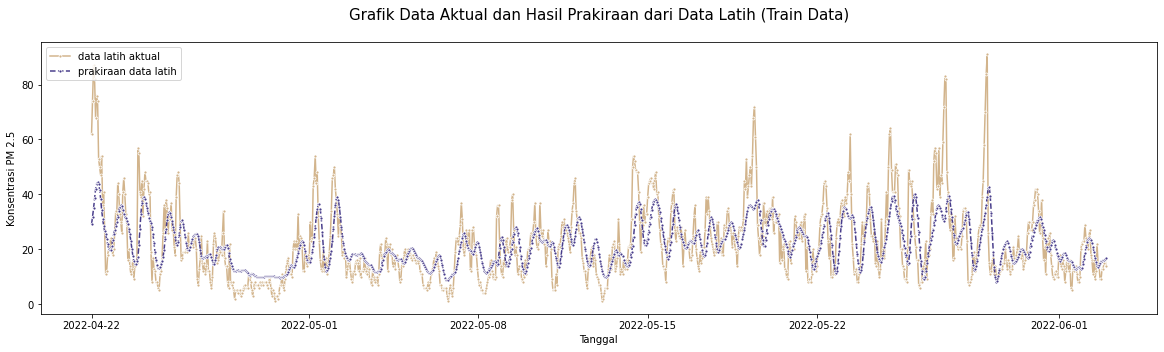

In [94]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [95]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  10.2
MAE:  7.41
MAPE:  0.3429


### Prediction with validation data

In [96]:
forecast_val_data = model_forecast(model3StackedGRU, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 1s 3ms/step
(361, 24)
(360,)
360


In [97]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([30.78855014, 34.52096224, 37.97850704, 40.96819401, 43.39808846])

In [98]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [99]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  30.788550
1   2022-06-04 01:00:00    58.0  34.520962
2   2022-06-04 02:00:00    63.0  37.978507
3   2022-06-04 03:00:00    70.0  40.968194
4   2022-06-04 04:00:00    72.0  43.398088
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  22.869469
356 2022-06-18 20:00:00    16.0  23.747944
357 2022-06-18 21:00:00    36.0  24.686467
358 2022-06-18 22:00:00    34.0  26.954484
359 2022-06-18 23:00:00    39.0  30.303049

[360 rows x 3 columns]

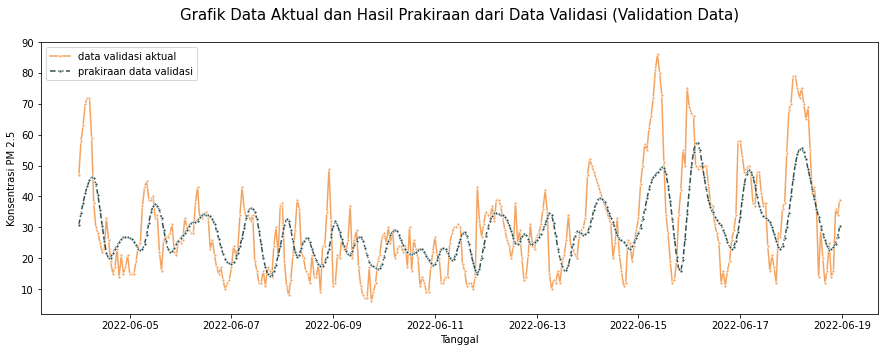

In [100]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [101]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  12.01
MAE:  9.17
MAPE:  0.3236


### Prediction with test data

In [102]:
forecast_test_data = model_forecast(model3StackedGRU, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 3ms/step
(49, 24)
(48,)
48


In [103]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([34.42908944, 36.91467036, 39.92672457, 42.47143461, 44.59326304])

In [104]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [105]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  34.429089
1  2022-06-20 01:00:00    48.0  36.914670
2  2022-06-20 02:00:00    38.0  39.926725
3  2022-06-20 03:00:00    47.0  42.471435
4  2022-06-20 04:00:00    69.0  44.593263
5  2022-06-20 05:00:00    77.0  47.385233
6  2022-06-20 06:00:00    79.0  50.680489
7  2022-06-20 07:00:00    79.0  53.856082
8  2022-06-20 08:00:00    68.0  56.277881
9  2022-06-20 09:00:00    54.0  57.056788
10 2022-06-20 10:00:00    50.0  56.070460
11 2022-06-20 11:00:00    36.0  53.624833
12 2022-06-20 12:00:00    42.0  49.585666
13 2022-06-20 13:00:00    43.0  44.816261
14 2022-06-20 14:00:00    35.0  40.438744
15 2022-06-20 15:00:00    32.0  36.640092
16 2022-06-20 16:00:00    27.0  33.704458
17 2022-06-20 17:00:00    27.0  31.365000
18 2022-06-20 18:00:00    23.0  29.784727
19 2022-06-20 19:00:00    35.0  29.076643
20 2022-06-20 20:00:00    41.0  29.811738
21 2022-06-20 21:00:00    41.0  32.237301
22 2022-06-20 22:00:00    38.0  35.605113
23 2022-06-20 23:00:00    39.0  39.057958
24 2022-06-21 00:00:00    37.0  42.114257
25 2022-06-21 01:00:00    44.0  44.345308
26 2022-06-21 02:00:00    46.0  45.999501
27 2022-06-21 03:00:00    33.0  47.162249
28 2022-06-21 04:00:00    28.0  46.835585
29 2022-06-21 05:00:00    27.0  44.748458
30 2022-06-21 06:00:00    45.0  41.369179
31 2022-06-21 07:00:00    64.0  38.792281
32 2022-06-21 08:00:00    58.0  38.979931
33 2022-06-21 09:00:00    44.0  41.206929
34 2022-06-21 10:00:00    27.0  43.600231
35 2022-06-21 11:00:00    27.0  44.115376
36 2022-06-21 12:00:00    24.0  42.364292
37 2022-06-21 13:00:00    26.0  39.177902
38 2022-06-21 14:00:00    22.0  35.569945
39 2022-06-21 15:00:00    22.0  32.216944
40 2022-06-21 16:00:00    21.0  29.537953
41 2022-06-21 17:00:00    28.0  27.918290
42 2022-06-21 18:00:00    30.0  27.462053
43 2022-06-21 19:00:00    43.0  28.056236
44 2022-06-21 20:00:00    41.0  30.305757
45 2022-06-21 21:00:00    54.0  33.684039
46 2022-06-21 22:00:00    42.0  38.319950
47 2022-06-21 23:00:00    36.0  42.581820

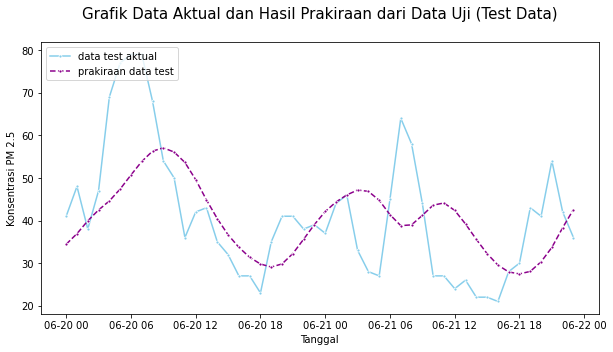

In [106]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [107]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  13.09
MAE:  10.4
MAPE:  0.2576


## Summary Eval Metric

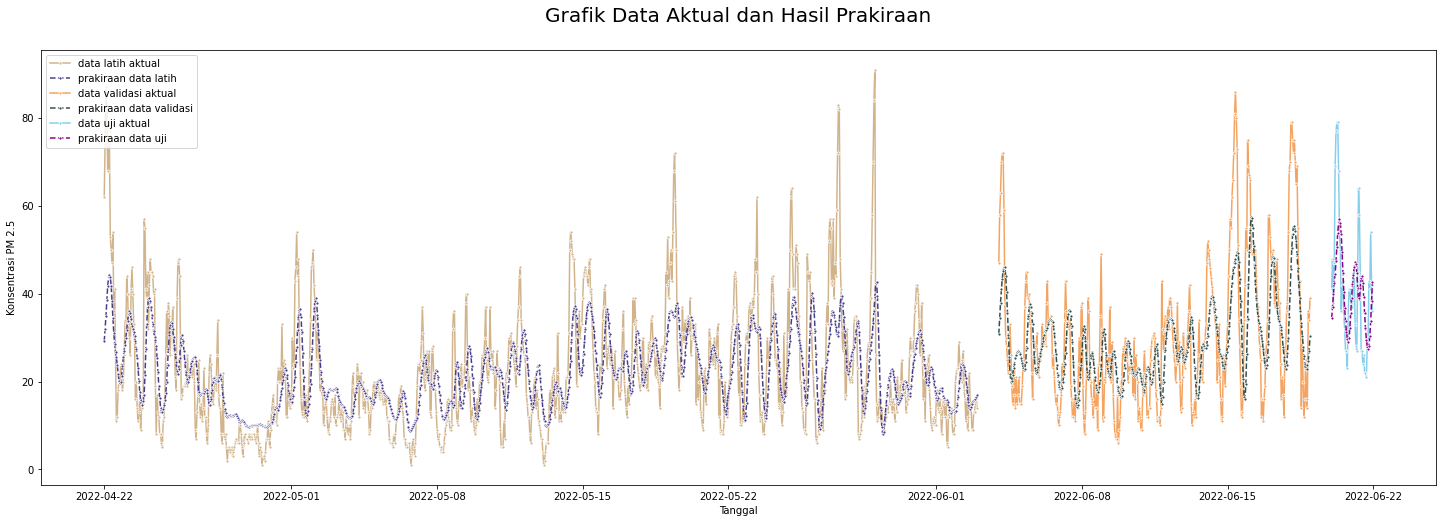

In [108]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [109]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  10.2
MAE:  7.41
MAPE:  0.3429
Forecast Val accuracy
RMSE:  12.01
MAE:  9.17
MAPE:  0.3236
Forecast Test accuracy
RMSE:  13.09
MAE:  10.4
MAPE:  0.2576


# Biderectional GRU

## Read Model

In [110]:
modelBiGRU = tf.keras.models.load_model('./Models/UnivariateForecast_BiGRU-Model.h5')

In [111]:
y_val_pred = modelBiGRU.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 0s 2ms/step
(337, 24)


In [112]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = modelBiGRU.evaluate(x_train_scaled, y_train_scaled, batch_size=64)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = modelBiGRU.evaluate(x_val_scaled, y_val_scaled, batch_size=64)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
16/16 [==============================] - 0s 2ms/step - loss: 0.3030 - mse: 0.7415
train loss, train mse: [0.303  0.7415]
Evaluate on val data
6/6 [==============================] - 0s 3ms/step - loss: 0.3125 - mse: 0.7586
val loss, val mse: [0.3125 0.7586]


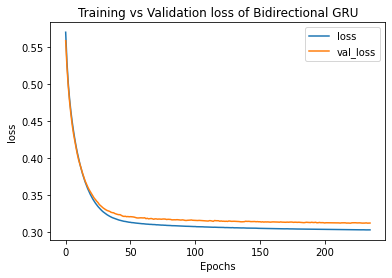

236


In [113]:
with open('./Models/historyBiGRU', "rb") as file_pi:
    load_historyBiGRU = pickle.load(file_pi)

plot_graphs(load_historyBiGRU, "loss", "Bidirectional GRU")
print(len(load_historyBiGRU['loss']))

## Prediction

### Prediction with training data

In [114]:
forecast_train_data = model_forecast(modelBiGRU, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

1009/1009 [==============================] - 2s 2ms/step
(1009, 24)
(1008,)
1008


In [115]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([41.15033527, 50.02382655, 59.6144466 , 69.15030475, 68.94180103])

In [116]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [117]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  41.150335
1    2022-04-22 01:00:00    74.0  50.023827
2    2022-04-22 02:00:00    87.0  59.614447
3    2022-04-22 03:00:00    82.0  69.150305
4    2022-04-22 04:00:00    68.0  68.941801
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  11.403441
1004 2022-06-02 20:00:00    13.0  14.203229
1005 2022-06-02 21:00:00    15.0  14.839260
1006 2022-06-02 22:00:00    16.0  15.621119
1007 2022-06-02 23:00:00    14.0  16.179716

[1008 rows x 3 columns]

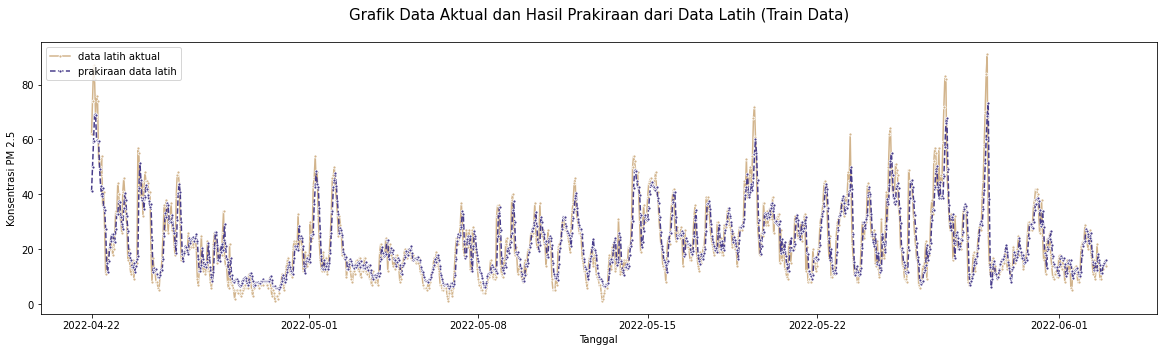

In [118]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [119]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  6.8
MAE:  4.89
MAPE:  0.2412


### Prediction with validation data

In [120]:
forecast_val_data = model_forecast(modelBiGRU, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 1s 2ms/step
(361, 24)
(360,)
360


In [121]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([40.98001671, 45.67182159, 53.66254234, 58.56752014, 62.12693405])

In [122]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [123]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  40.980017
1   2022-06-04 01:00:00    58.0  45.671822
2   2022-06-04 02:00:00    63.0  53.662542
3   2022-06-04 03:00:00    70.0  58.567520
4   2022-06-04 04:00:00    72.0  62.126934
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  24.068499
356 2022-06-18 20:00:00    16.0  21.692751
357 2022-06-18 21:00:00    36.0  21.003320
358 2022-06-18 22:00:00    34.0  32.658790
359 2022-06-18 23:00:00    39.0  37.199594

[360 rows x 3 columns]

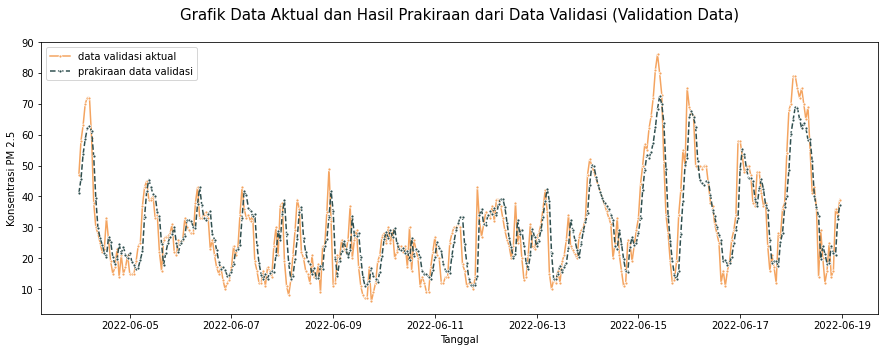

In [124]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [125]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  7.66
MAE:  5.92
MAPE:  0.223


### Prediction with test data

In [126]:
forecast_test_data = model_forecast(modelBiGRU, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 2ms/step
(49, 24)
(48,)
48


In [127]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([35.47006978, 40.77947466, 48.24013366, 43.26631106, 46.93787135])

In [128]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [129]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  35.470070
1  2022-06-20 01:00:00    48.0  40.779475
2  2022-06-20 02:00:00    38.0  48.240134
3  2022-06-20 03:00:00    47.0  43.266311
4  2022-06-20 04:00:00    69.0  46.937871
5  2022-06-20 05:00:00    77.0  60.193362
6  2022-06-20 06:00:00    79.0  70.471810
7  2022-06-20 07:00:00    79.0  73.255017
8  2022-06-20 08:00:00    68.0  70.809642
9  2022-06-20 09:00:00    54.0  63.661942
10 2022-06-20 10:00:00    50.0  53.564926
11 2022-06-20 11:00:00    36.0  48.263760
12 2022-06-20 12:00:00    42.0  37.622946
13 2022-06-20 13:00:00    43.0  39.379623
14 2022-06-20 14:00:00    35.0  41.054122
15 2022-06-20 15:00:00    32.0  35.546535
16 2022-06-20 16:00:00    27.0  31.083750
17 2022-06-20 17:00:00    27.0  26.750340
18 2022-06-20 18:00:00    23.0  25.962792
19 2022-06-20 19:00:00    35.0  25.523322
20 2022-06-20 20:00:00    41.0  31.809124
21 2022-06-20 21:00:00    41.0  39.608079
22 2022-06-20 22:00:00    38.0  43.816316
23 2022-06-20 23:00:00    39.0  42.379475
24 2022-06-21 00:00:00    37.0  41.980348
25 2022-06-21 01:00:00    44.0  41.341535
26 2022-06-21 02:00:00    46.0  47.359475
27 2022-06-21 03:00:00    33.0  49.264128
28 2022-06-21 04:00:00    28.0  38.594444
29 2022-06-21 05:00:00    27.0  29.741836
30 2022-06-21 06:00:00    45.0  25.294122
31 2022-06-21 07:00:00    64.0  36.662587
32 2022-06-21 08:00:00    58.0  54.076703
33 2022-06-21 09:00:00    44.0  58.649178
34 2022-06-21 10:00:00    27.0  50.035575
35 2022-06-21 11:00:00    27.0  34.150514
36 2022-06-21 12:00:00    24.0  27.335881
37 2022-06-21 13:00:00    26.0  25.452840
38 2022-06-21 14:00:00    22.0  27.351390
39 2022-06-21 15:00:00    22.0  25.937359
40 2022-06-21 16:00:00    21.0  24.339614
41 2022-06-21 17:00:00    28.0  22.776702
42 2022-06-21 18:00:00    30.0  25.504931
43 2022-06-21 19:00:00    43.0  29.425684
44 2022-06-21 20:00:00    41.0  41.047857
45 2022-06-21 21:00:00    54.0  44.687542
46 2022-06-21 22:00:00    42.0  53.125788
47 2022-06-21 23:00:00    36.0  47.987316

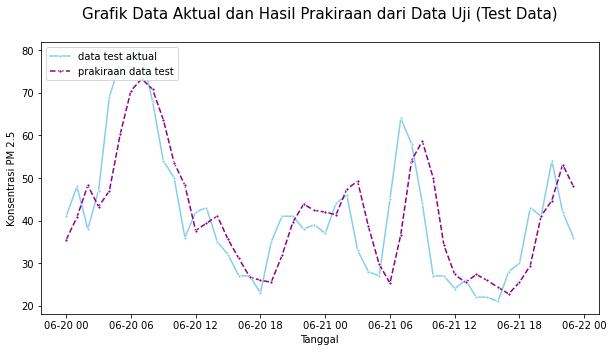

In [130]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [131]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  9.88
MAE:  7.69
MAPE:  0.1937


## Summary Eval Metric

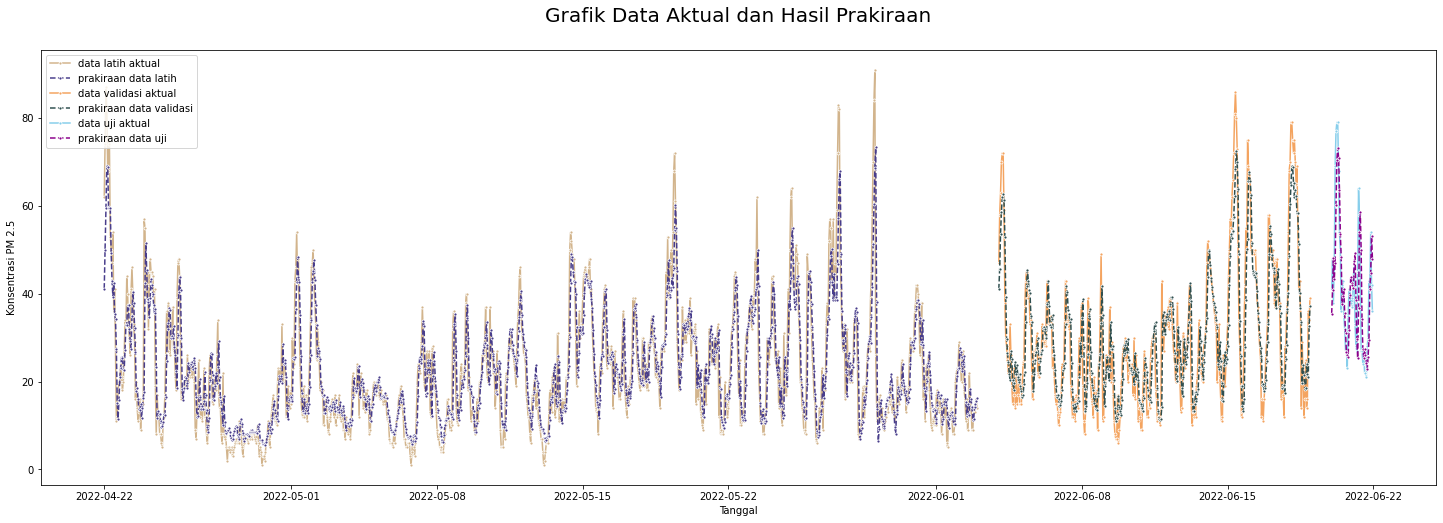

In [132]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [133]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  6.8
MAE:  4.89
MAPE:  0.2412
Forecast Val accuracy
RMSE:  7.66
MAE:  5.92
MAPE:  0.223
Forecast Test accuracy
RMSE:  9.88
MAE:  7.69
MAPE:  0.1937


## Future Values

In [134]:
from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt.strftime('%Y-%m-%d %H:%M') for dt in 
       datetime_range(datetime(2022, 6, 22, 0), datetime(2022, 6, 23, 0), 
       timedelta(minutes=60))]

# dts=np.array(dts)
print(dts)
print(np.shape(dts))

['2022-06-22 00:00', '2022-06-22 01:00', '2022-06-22 02:00', '2022-06-22 03:00', '2022-06-22 04:00', '2022-06-22 05:00', '2022-06-22 06:00', '2022-06-22 07:00', '2022-06-22 08:00', '2022-06-22 09:00', '2022-06-22 10:00', '2022-06-22 11:00', '2022-06-22 12:00', '2022-06-22 13:00', '2022-06-22 14:00', '2022-06-22 15:00', '2022-06-22 16:00', '2022-06-22 17:00', '2022-06-22 18:00', '2022-06-22 19:00', '2022-06-22 20:00', '2022-06-22 21:00', '2022-06-22 22:00', '2022-06-22 23:00']
(24,)


### with 24 data

In [135]:
pm2p5_scaled = normalize_series(pm2p5, Average(pm2p5), stdev(pm2p5_train.flatten()))

In [136]:
X_future = pm2p5_scaled[- n_lookback:].reshape(1, n_lookback, 1)
y_future = modelBiGRU.predict(X_future)
print(y_future.shape)

y_future = inverse_normalize_series(y_future, Average(pm2p5), stdev(pm2p5_train.flatten()))
forecast_future_data = y_future[0]
print(forecast_future_data.shape)
print(forecast_future_data[:5])

1/1 [==============================] - 0s 16ms/step
(1, 24)
(24,)
[38.45511477 37.11332458 35.56752055 34.7013964  33.53250545]


In [137]:
df_forecast = pd.DataFrame(columns=['Date', 'Forecast'])
df_forecast['Date'] = dts
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast['Forecast'] = forecast_future_data
df_forecast

Date   Forecast
0  2022-06-22 00:00:00  38.455115
1  2022-06-22 01:00:00  37.113325
2  2022-06-22 02:00:00  35.567521
3  2022-06-22 03:00:00  34.701396
4  2022-06-22 04:00:00  33.532505
5  2022-06-22 05:00:00  32.723164
6  2022-06-22 06:00:00  31.030948
7  2022-06-22 07:00:00  28.561422
8  2022-06-22 08:00:00  25.507923
9  2022-06-22 09:00:00  23.724085
10 2022-06-22 10:00:00  22.825004
11 2022-06-22 11:00:00  22.517041
12 2022-06-22 12:00:00  23.418269
13 2022-06-22 13:00:00  24.139689
14 2022-06-22 14:00:00  24.753789
15 2022-06-22 15:00:00  25.208261
16 2022-06-22 16:00:00  25.475983
17 2022-06-22 17:00:00  26.881939
18 2022-06-22 18:00:00  29.017773
19 2022-06-22 19:00:00  30.615886
20 2022-06-22 20:00:00  30.294258
21 2022-06-22 21:00:00  29.717039
22 2022-06-22 22:00:00  30.331056
23 2022-06-22 23:00:00  30.446129

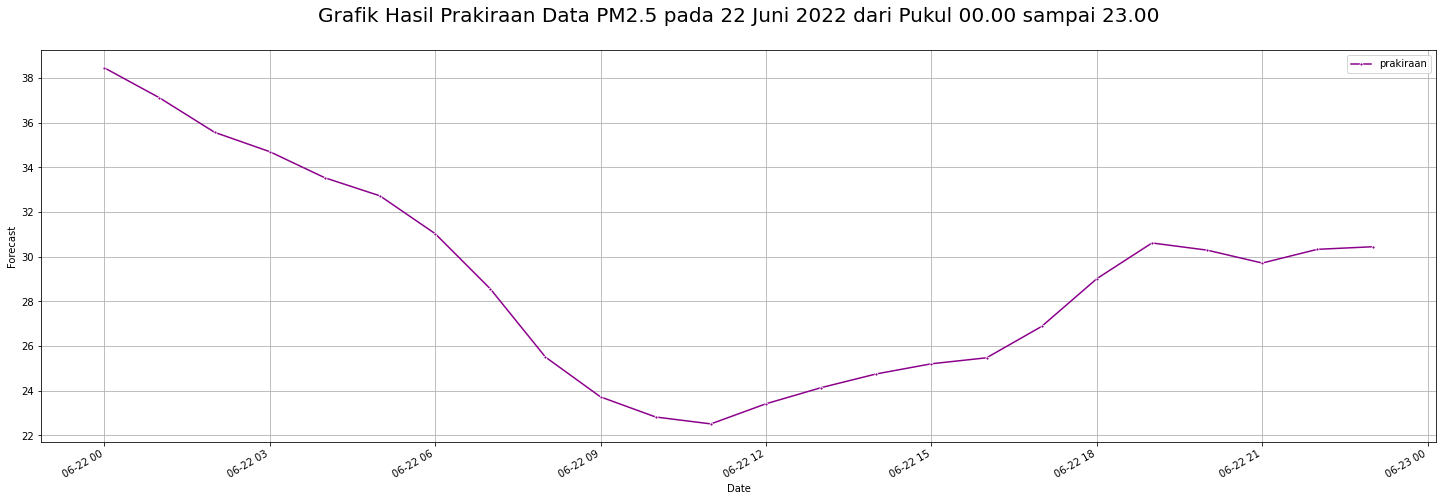

In [138]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="prakiraan", marker='.', color='darkmagenta')
fig.autofmt_xdate()
plt.title("Grafik Hasil Prakiraan Data PM2.5 pada 22 Juni 2022 dari Pukul 00.00 sampai 23.00\n", fontsize = 20)
plt.grid()

Text(0.5, 1.0, 'Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n')

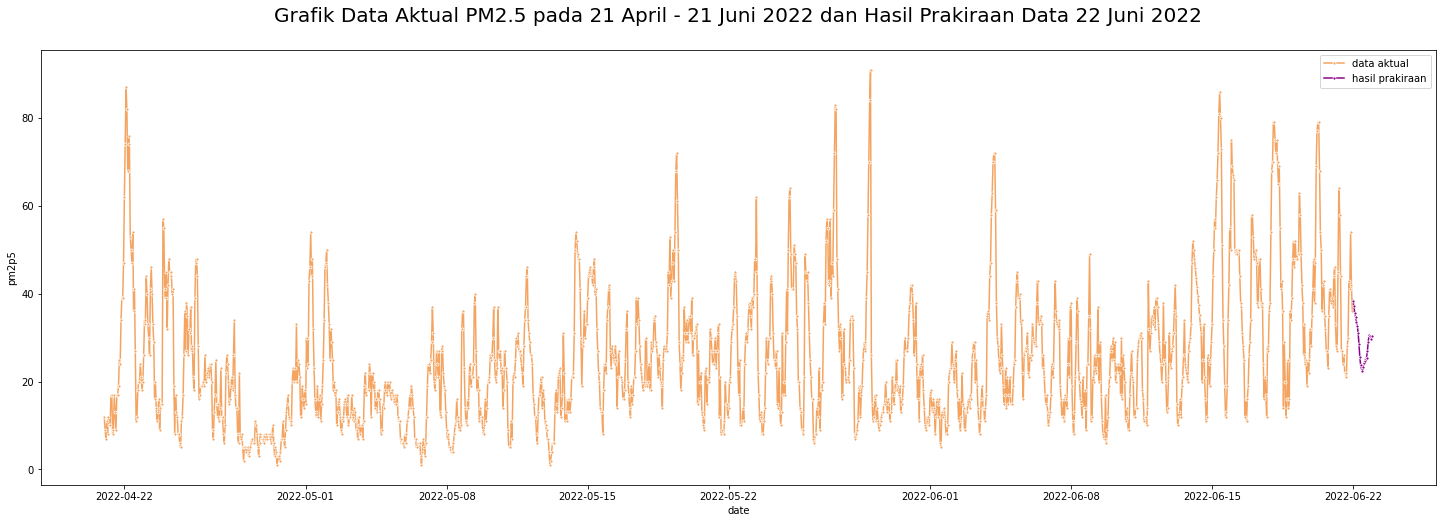

In [139]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="date", y="pm2p5", data=dataset, 
                    label="data aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="hasil prakiraan", marker='.', color='darkmagenta')
plt.title("Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n", fontsize = 20)

### with all data method I

In [140]:
# X_ = pm2p5_scaled[-2*n_lookback:]
X_future = []

for i in range(n_lookback, len(pm2p5_scaled)+1):
    X_future.append(pm2p5_scaled[i - n_lookback: i])
    # y_train.append(pm2p5_train[i: i + n_forecast])

X_future = np.array(X_future)
print(X_future.shape)
# print(X_future[-1])

(1465, 24, 1)


In [141]:
y_future = modelBiGRU.predict(X_future)
print(y_future.shape)

y_future = inverse_normalize_series(y_future, Average(pm2p5), stdev(pm2p5_train.flatten()))
forecast_future_data = y_future[-1]
print(forecast_future_data.shape)
print(forecast_future_data[:5])

46/46 [==============================] - 0s 3ms/step
(1465, 24)
(24,)
[38.45511477 37.11332458 35.56751864 34.70139735 33.53250449]


In [142]:
df_forecast = pd.DataFrame(columns=['Date', 'Forecast'])
df_forecast['Date'] = dts
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast['Forecast'] = np.round(forecast_future_data, 3)
df_forecast

Date  Forecast
0  2022-06-22 00:00:00    38.455
1  2022-06-22 01:00:00    37.113
2  2022-06-22 02:00:00    35.568
3  2022-06-22 03:00:00    34.701
4  2022-06-22 04:00:00    33.533
5  2022-06-22 05:00:00    32.723
6  2022-06-22 06:00:00    31.031
7  2022-06-22 07:00:00    28.561
8  2022-06-22 08:00:00    25.508
9  2022-06-22 09:00:00    23.724
10 2022-06-22 10:00:00    22.825
11 2022-06-22 11:00:00    22.517
12 2022-06-22 12:00:00    23.418
13 2022-06-22 13:00:00    24.140
14 2022-06-22 14:00:00    24.754
15 2022-06-22 15:00:00    25.208
16 2022-06-22 16:00:00    25.476
17 2022-06-22 17:00:00    26.882
18 2022-06-22 18:00:00    29.018
19 2022-06-22 19:00:00    30.616
20 2022-06-22 20:00:00    30.294
21 2022-06-22 21:00:00    29.717
22 2022-06-22 22:00:00    30.331
23 2022-06-22 23:00:00    30.446

In [143]:
df_forecast.describe()

Forecast
count  24.000000
mean   29.023292
std     4.674235
min    22.517000
25%    25.094500
50%    29.367500
75%    31.454000
max    38.455000

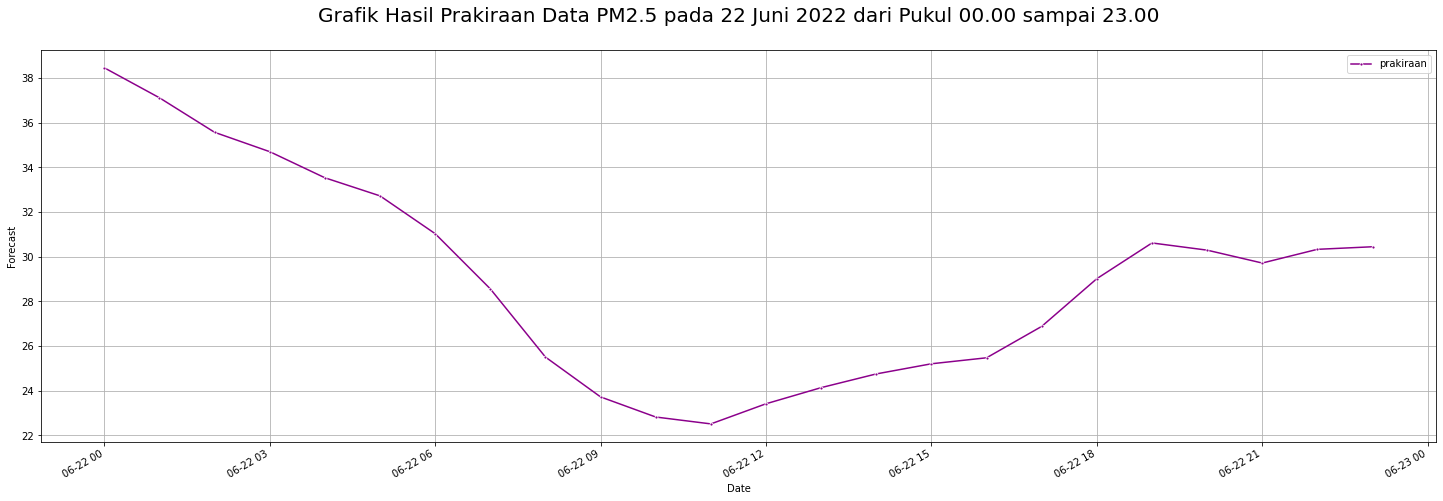

In [144]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="prakiraan", marker='.', color='darkmagenta')
fig.autofmt_xdate()
plt.title("Grafik Hasil Prakiraan Data PM2.5 pada 22 Juni 2022 dari Pukul 00.00 sampai 23.00\n", fontsize = 20)
plt.grid()

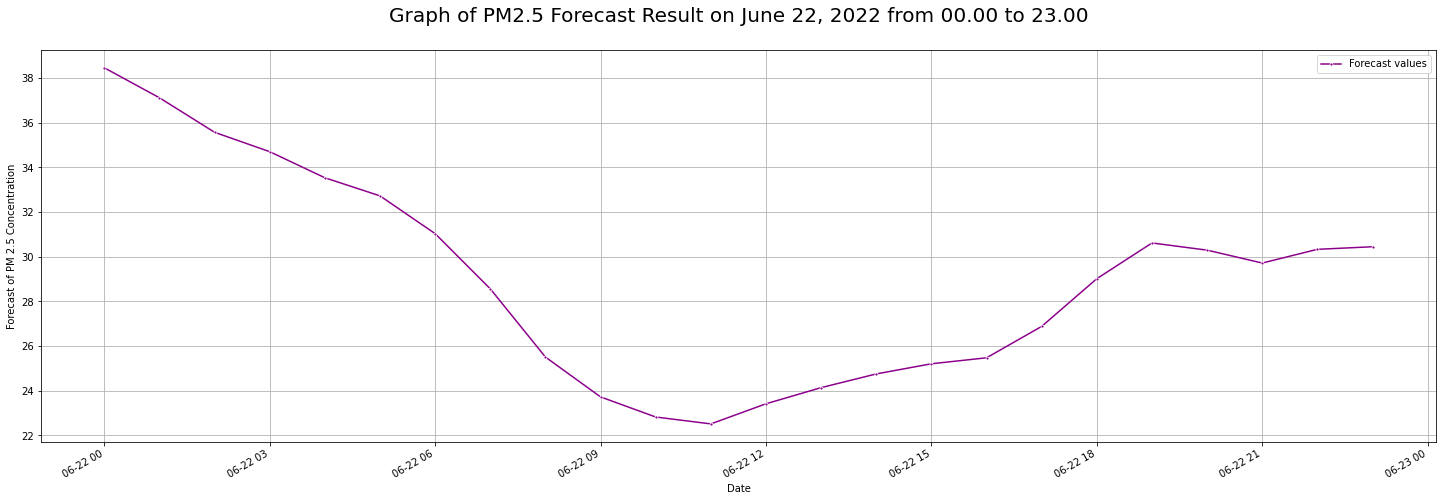

In [145]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="Forecast values", marker='.', color='darkmagenta')
fig.autofmt_xdate()
plt.title("Graph of PM2.5 Forecast Result on June 22, 2022 from 00.00 to 23.00\n", fontsize = 20)
plt.xlabel('Date'); plt.ylabel('Forecast of PM 2.5 Concentration')
plt.grid()

Text(0.5, 1.0, 'Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n')

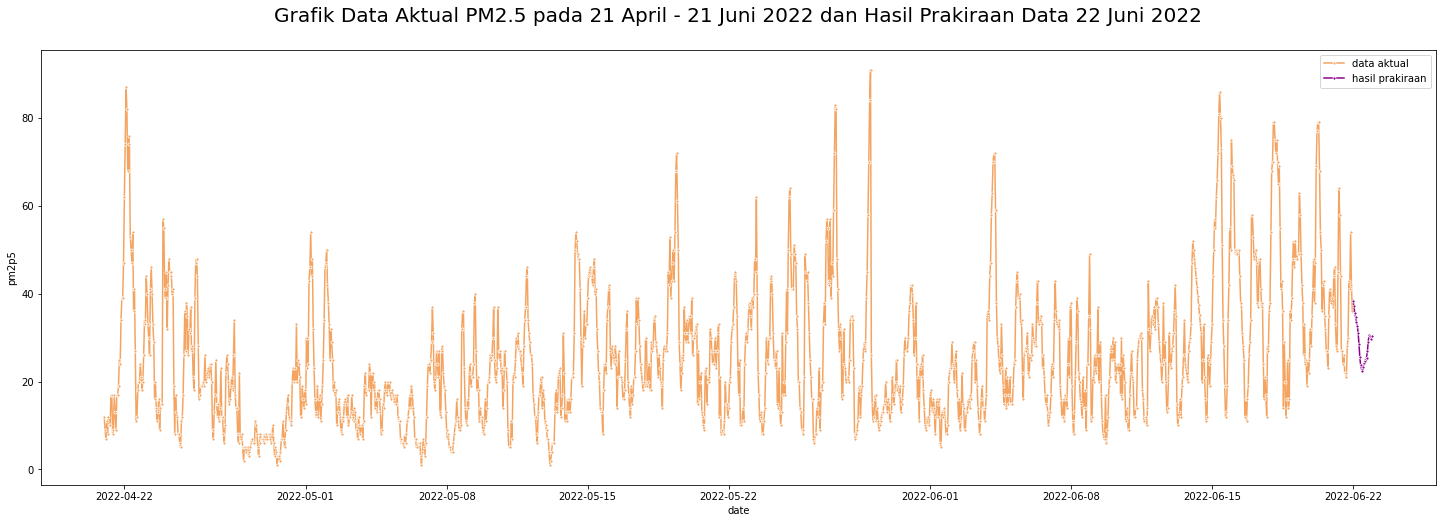

In [146]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="date", y="pm2p5", data=dataset, 
                    label="data aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="hasil prakiraan", marker='.', color='darkmagenta')
plt.title("Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n", fontsize = 20)

Text(0.5, 1.0, 'Graph of Actual PM2.5 Data on April 21 - June 21, 2022 and Forecast Result on June 22, 2022\n')

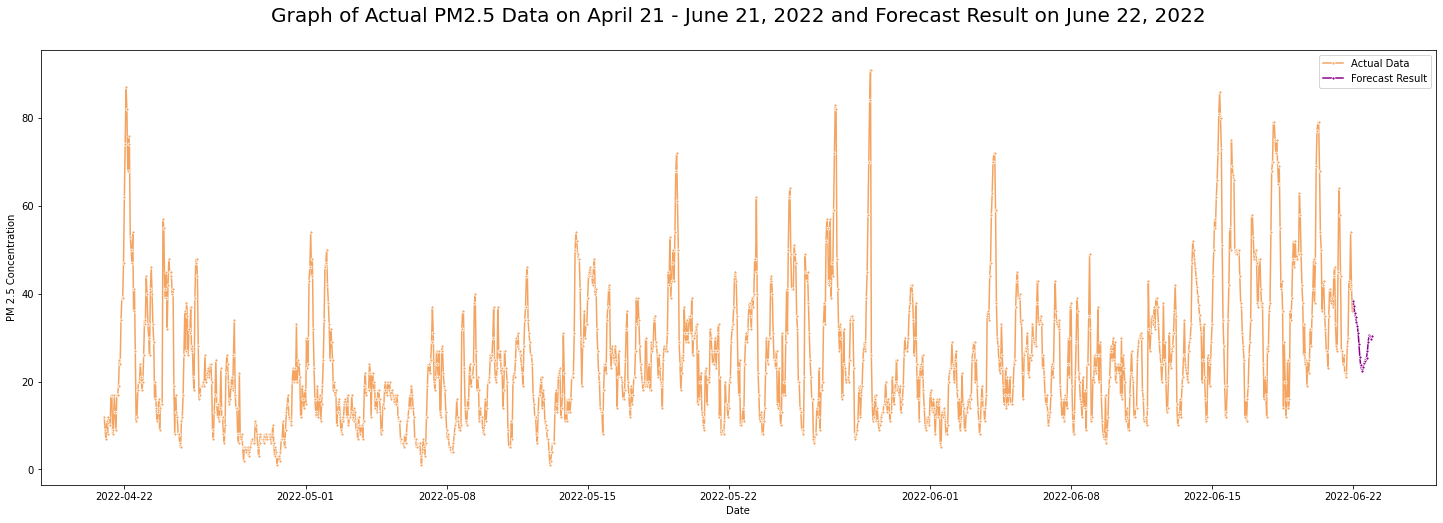

In [147]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="date", y="pm2p5", data=dataset, 
                    label="Actual Data", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="Forecast Result", marker='.', color='darkmagenta')
plt.xlabel('Date'); plt.ylabel('PM 2.5 Concentration')
plt.title("Graph of Actual PM2.5 Data on April 21 - June 21, 2022 and Forecast Result on June 22, 2022\n", fontsize = 20)

### with all data method II

In [148]:
# generate the forecasts
y_future = model_forecast(modelBiGRU, pm2p5_scaled, n_lookback, 1)
print(y_future.shape)

y_future = inverse_normalize_series(y_future, Average(pm2p5), stdev(pm2p5_train.flatten()))
forecast_future_data = y_future[-1]
print(forecast_future_data.shape)
print(forecast_future_data[:5])

1465/1465 [==============================] - 3s 2ms/step
(1465, 24)
(24,)
[38.45511477 37.11332458 35.56752055 34.7013964  33.53250545]


In [149]:
df_forecast = pd.DataFrame(columns=['Date', 'Forecast'])
df_forecast['Date'] = dts
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast['Forecast'] = forecast_future_data
df_forecast

Date   Forecast
0  2022-06-22 00:00:00  38.455115
1  2022-06-22 01:00:00  37.113325
2  2022-06-22 02:00:00  35.567521
3  2022-06-22 03:00:00  34.701396
4  2022-06-22 04:00:00  33.532505
5  2022-06-22 05:00:00  32.723164
6  2022-06-22 06:00:00  31.030948
7  2022-06-22 07:00:00  28.561422
8  2022-06-22 08:00:00  25.507923
9  2022-06-22 09:00:00  23.724085
10 2022-06-22 10:00:00  22.825004
11 2022-06-22 11:00:00  22.517041
12 2022-06-22 12:00:00  23.418269
13 2022-06-22 13:00:00  24.139689
14 2022-06-22 14:00:00  24.753789
15 2022-06-22 15:00:00  25.208261
16 2022-06-22 16:00:00  25.475983
17 2022-06-22 17:00:00  26.881939
18 2022-06-22 18:00:00  29.017773
19 2022-06-22 19:00:00  30.615886
20 2022-06-22 20:00:00  30.294258
21 2022-06-22 21:00:00  29.717039
22 2022-06-22 22:00:00  30.331056
23 2022-06-22 23:00:00  30.446129

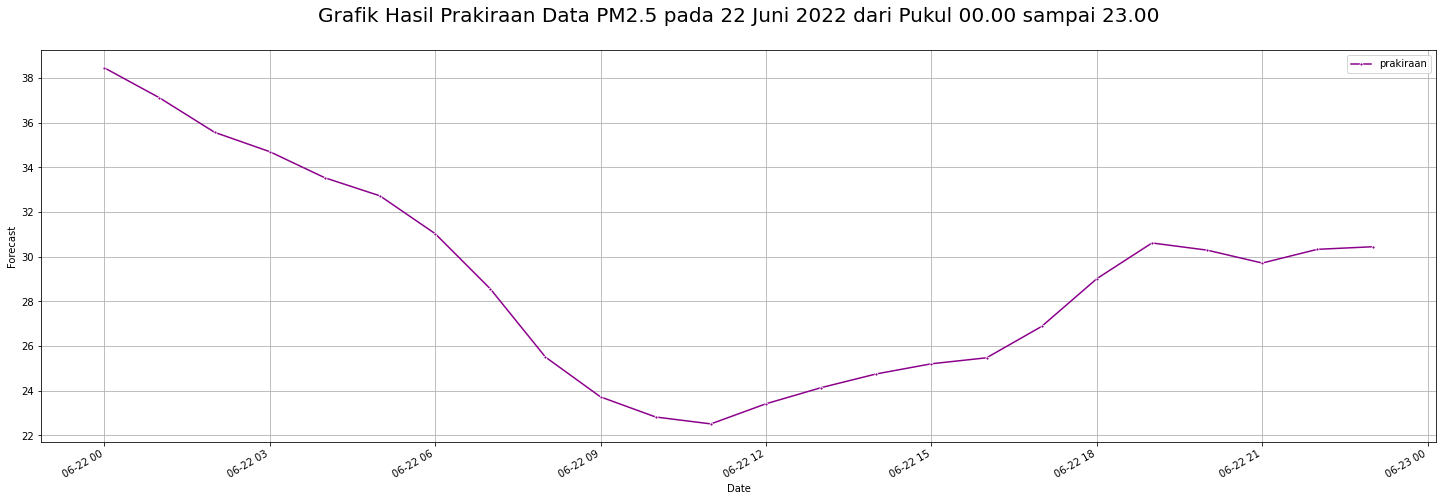

In [150]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="prakiraan", marker='.', color='darkmagenta')
fig.autofmt_xdate()
plt.title("Grafik Hasil Prakiraan Data PM2.5 pada 22 Juni 2022 dari Pukul 00.00 sampai 23.00\n", fontsize = 20)
plt.grid()

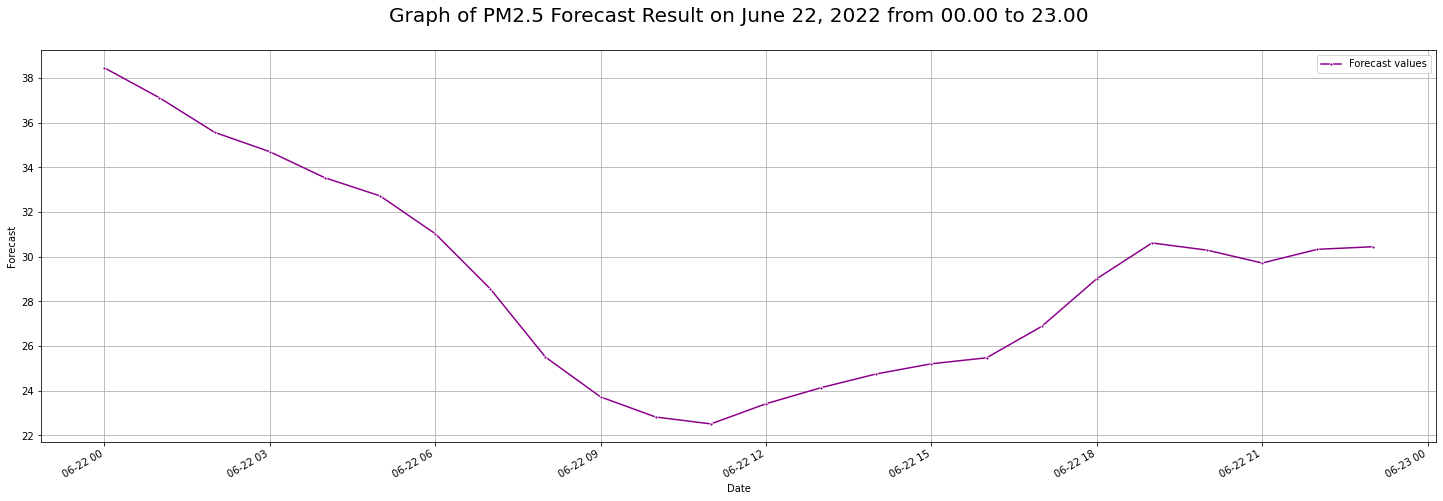

In [151]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="Forecast values", marker='.', color='darkmagenta')
fig.autofmt_xdate()
plt.title("Graph of PM2.5 Forecast Result on June 22, 2022 from 00.00 to 23.00\n", fontsize = 20)
plt.grid()

Text(0.5, 1.0, 'Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n')

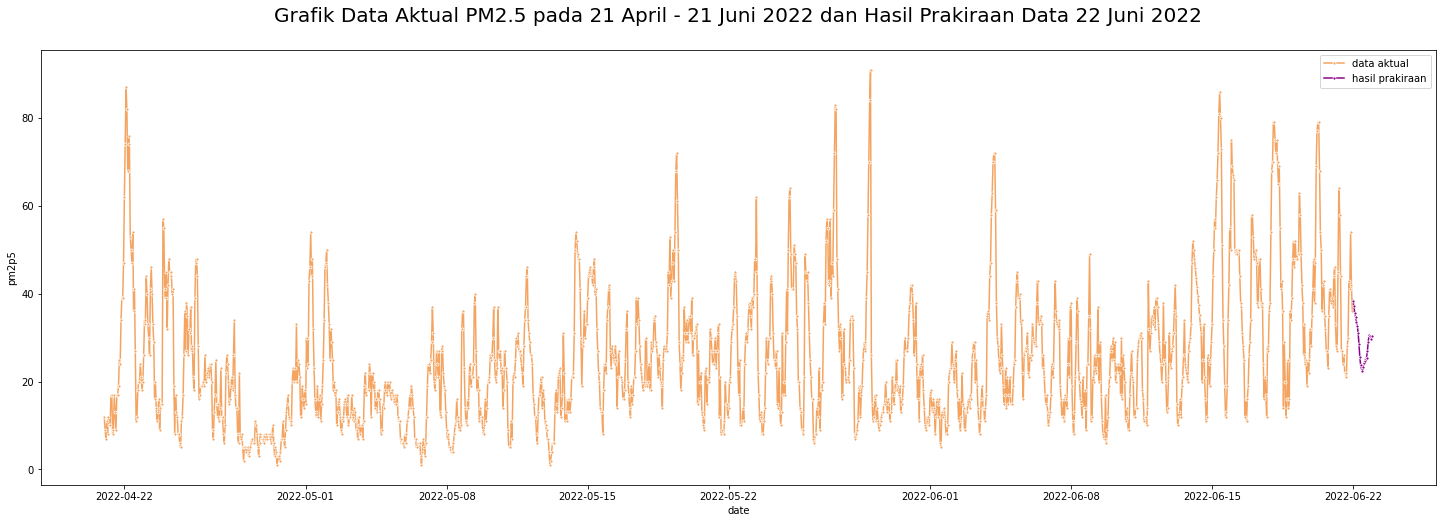

In [152]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="date", y="pm2p5", data=dataset, 
                    label="data aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="hasil prakiraan", marker='.', color='darkmagenta')
plt.title("Grafik Data Aktual PM2.5 pada 21 April - 21 Juni 2022 dan Hasil Prakiraan Data 22 Juni 2022\n", fontsize = 20)

Text(0.5, 1.0, 'Graph of Actual PM2.5 Data on April 21 - June 21, 2022 and Forecast Result on June 22, 2022\n')

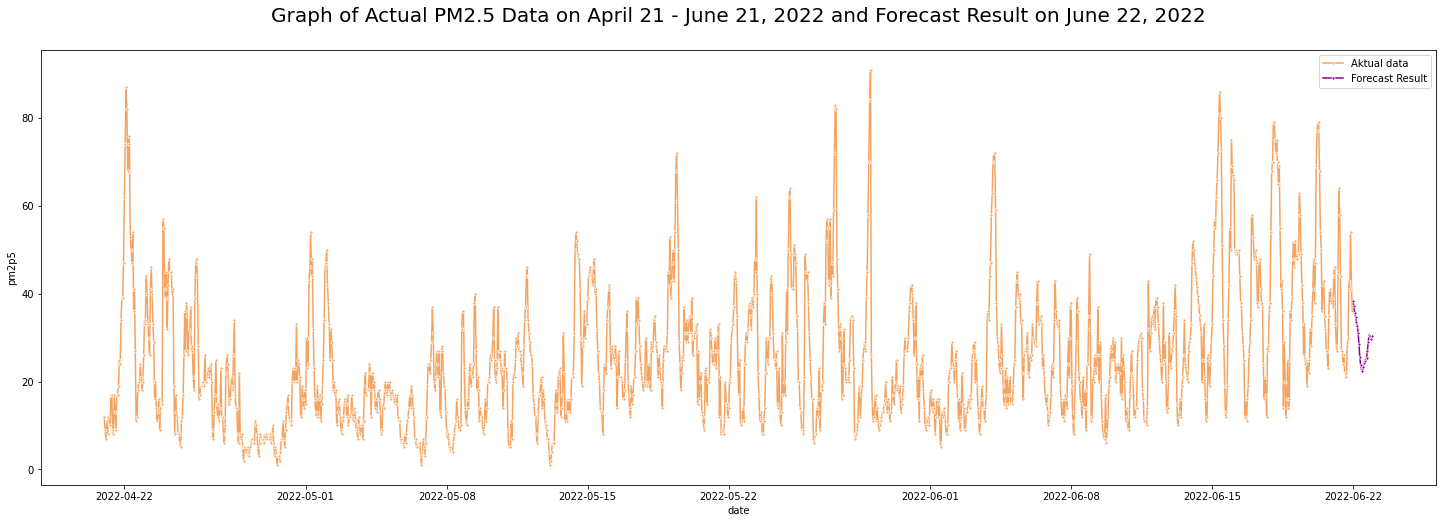

In [153]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="date", y="pm2p5", data=dataset, 
                    label="Aktual data", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_forecast, 
                    label="Forecast Result", marker='.', color='darkmagenta')
plt.title("Graph of Actual PM2.5 Data on April 21 - June 21, 2022 and Forecast Result on June 22, 2022\n", fontsize = 20)

# 2 Stacked Biderectional GRU

## Read Model

In [154]:
model2StackedBiGRU = tf.keras.models.load_model('./Models/UnivariateForecast_2StackedBiGRU-Model.h5')

In [155]:
y_val_pred = model2StackedBiGRU.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 0s 3ms/step
(337, 24)


In [156]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = model2StackedBiGRU.evaluate(x_train_scaled, y_train_scaled, batch_size=64)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = model2StackedBiGRU.evaluate(x_val_scaled, y_val_scaled, batch_size=64)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
16/16 [==============================] - 0s 3ms/step - loss: 0.3161 - mse: 0.7613
train loss, train mse: [0.3161 0.7613]
Evaluate on val data
6/6 [==============================] - 0s 4ms/step - loss: 0.3194 - mse: 0.7613
val loss, val mse: [0.3194 0.7613]


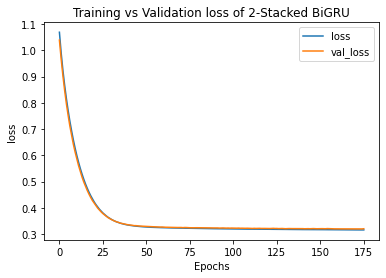

176


In [157]:
with open('./Models/history2StackedBiGRU', "rb") as file_pi:
    load_history2StackedBiGRU = pickle.load(file_pi)

plot_graphs(load_history2StackedBiGRU, "loss", "2-Stacked BiGRU")
print(len(load_history2StackedBiGRU['loss']))

## Prediction

### Prediction with training data

In [158]:
forecast_train_data = model_forecast(model2StackedBiGRU, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

1009/1009 [==============================] - 3s 3ms/step
(1009, 24)
(1008,)
1008


In [159]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([39.06207652, 43.74067493, 48.50745387, 53.86455531, 56.1925983 ])

In [160]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [161]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  39.062077
1    2022-04-22 01:00:00    74.0  43.740675
2    2022-04-22 02:00:00    87.0  48.507454
3    2022-04-22 03:00:00    82.0  53.864555
4    2022-04-22 04:00:00    68.0  56.192598
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  13.325648
1004 2022-06-02 20:00:00    13.0  13.713164
1005 2022-06-02 21:00:00    15.0  14.062917
1006 2022-06-02 22:00:00    16.0  14.778910
1007 2022-06-02 23:00:00    14.0  15.544834

[1008 rows x 3 columns]

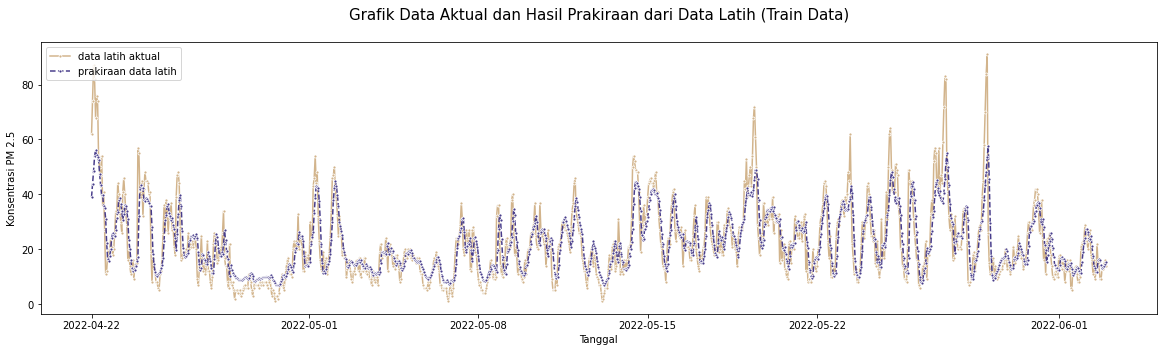

In [162]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [163]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  7.83
MAE:  5.58
MAPE:  0.2666


### Prediction with validation data

In [164]:
forecast_val_data = model_forecast(model2StackedBiGRU, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 1s 3ms/step
(361, 24)
(360,)
360


In [165]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([40.46360779, 44.12860012, 48.93907356, 52.21180344, 54.80472183])

In [166]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [167]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  40.463608
1   2022-06-04 01:00:00    58.0  44.128600
2   2022-06-04 02:00:00    63.0  48.939074
3   2022-06-04 03:00:00    70.0  52.211803
4   2022-06-04 04:00:00    72.0  54.804722
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  22.022206
356 2022-06-18 20:00:00    16.0  21.882758
357 2022-06-18 21:00:00    36.0  22.150172
358 2022-06-18 22:00:00    34.0  30.099883
359 2022-06-18 23:00:00    39.0  35.860709

[360 rows x 3 columns]

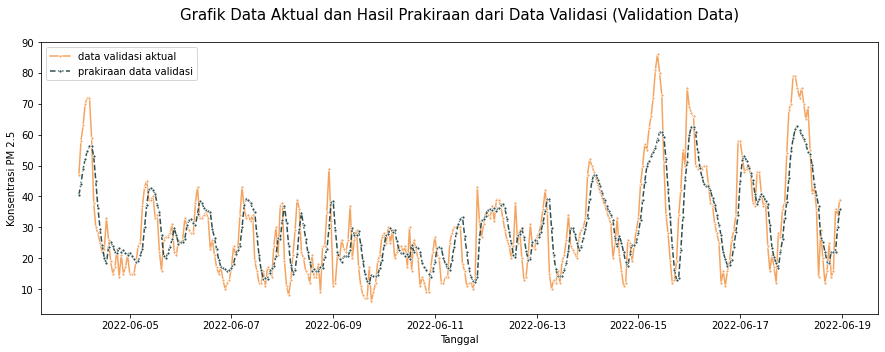

In [168]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [169]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  8.97
MAE:  6.99
MAPE:  0.2545


### Prediction with test data

In [170]:
forecast_test_data = model_forecast(model2StackedBiGRU, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 3ms/step
(49, 24)
(48,)
48


In [171]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([34.71172322, 39.34946896, 45.1835574 , 44.48066653, 47.0333351 ])

In [172]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [173]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  34.711723
1  2022-06-20 01:00:00    48.0  39.349469
2  2022-06-20 02:00:00    38.0  45.183557
3  2022-06-20 03:00:00    47.0  44.480667
4  2022-06-20 04:00:00    69.0  47.033335
5  2022-06-20 05:00:00    77.0  55.404184
6  2022-06-20 06:00:00    79.0  61.916091
7  2022-06-20 07:00:00    79.0  65.323424
8  2022-06-20 08:00:00    68.0  66.400296
9  2022-06-20 09:00:00    54.0  63.894542
10 2022-06-20 10:00:00    50.0  57.820193
11 2022-06-20 11:00:00    36.0  52.077619
12 2022-06-20 12:00:00    42.0  42.414450
13 2022-06-20 13:00:00    43.0  39.303627
14 2022-06-20 14:00:00    35.0  38.711675
15 2022-06-20 15:00:00    32.0  34.846682
16 2022-06-20 16:00:00    27.0  31.897151
17 2022-06-20 17:00:00    27.0  29.209521
18 2022-06-20 18:00:00    23.0  28.037705
19 2022-06-20 19:00:00    35.0  27.328899
20 2022-06-20 20:00:00    41.0  30.640666
21 2022-06-20 21:00:00    41.0  37.065638
22 2022-06-20 22:00:00    38.0  41.987949
23 2022-06-20 23:00:00    39.0  43.220034
24 2022-06-21 00:00:00    37.0  43.877146
25 2022-06-21 01:00:00    44.0  42.861083
26 2022-06-21 02:00:00    46.0  45.209904
27 2022-06-21 03:00:00    33.0  46.918588
28 2022-06-21 04:00:00    28.0  41.563283
29 2022-06-21 05:00:00    27.0  35.634182
30 2022-06-21 06:00:00    45.0  31.103440
31 2022-06-21 07:00:00    64.0  35.687418
32 2022-06-21 08:00:00    58.0  46.492110
33 2022-06-21 09:00:00    44.0  52.542335
34 2022-06-21 10:00:00    27.0  51.612995
35 2022-06-21 11:00:00    27.0  42.875470
36 2022-06-21 12:00:00    24.0  35.163371
37 2022-06-21 13:00:00    26.0  29.337138
38 2022-06-21 14:00:00    22.0  26.730948
39 2022-06-21 15:00:00    22.0  24.792703
40 2022-06-21 16:00:00    21.0  24.270854
41 2022-06-21 17:00:00    28.0  24.271914
42 2022-06-21 18:00:00    30.0  26.550651
43 2022-06-21 19:00:00    43.0  29.204954
44 2022-06-21 20:00:00    41.0  37.196640
45 2022-06-21 21:00:00    54.0  42.160318
46 2022-06-21 22:00:00    42.0  49.490134
47 2022-06-21 23:00:00    36.0  49.402165

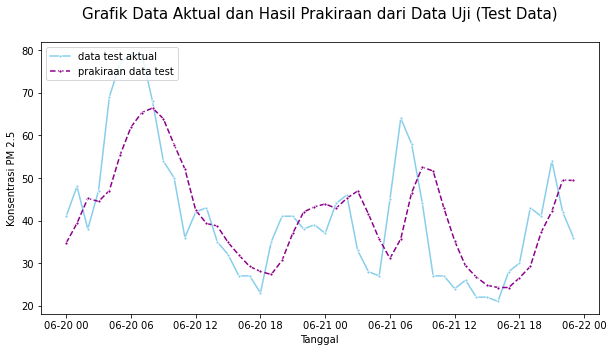

In [174]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [175]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  10.87
MAE:  8.7
MAPE:  0.2119


## Summary Eval Metric

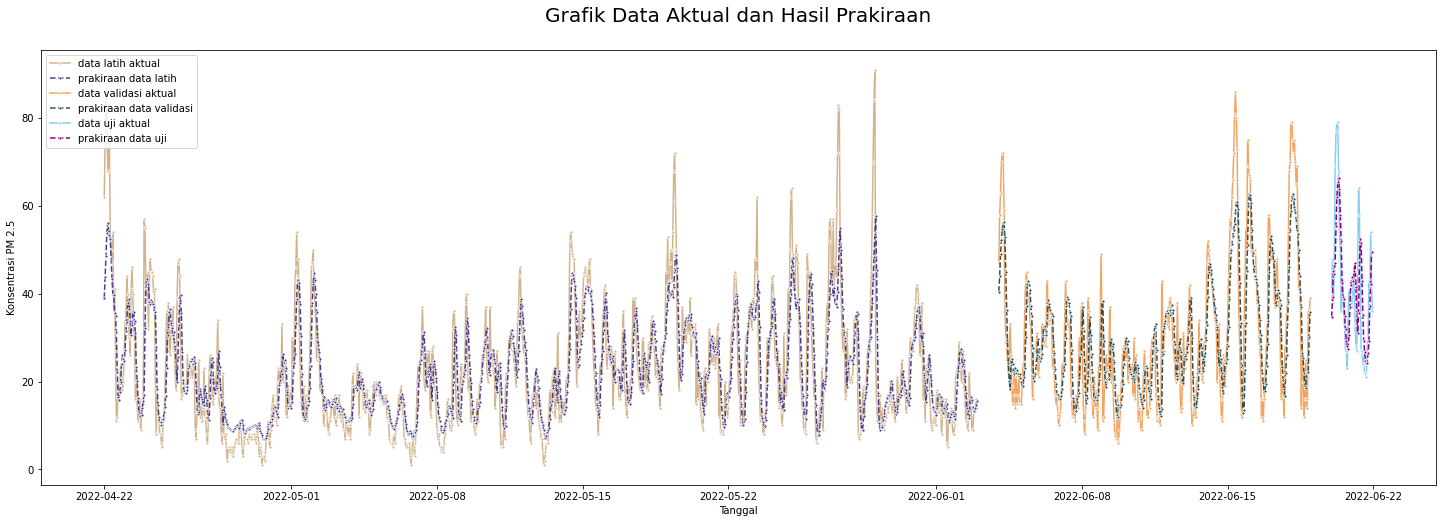

In [176]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [177]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  7.83
MAE:  5.58
MAPE:  0.2666
Forecast Val accuracy
RMSE:  8.97
MAE:  6.99
MAPE:  0.2545
Forecast Test accuracy
RMSE:  10.87
MAE:  8.7
MAPE:  0.2119


# 3 Stacked Biderectional GRU

## Read Model

In [178]:
model3StackedBiGRU = tf.keras.models.load_model('./Models/UnivariateForecast_3StackedBiGRU-Model.h5')

In [179]:
y_val_pred = model3StackedBiGRU.predict(x_val_scaled)
# y_val_pred = scaler.inverse_transform(y_val_pred)
print(y_val_pred.shape)

11/11 [==============================] - 1s 5ms/step
(337, 24)


In [180]:
# Evaluate the model on the train data using `evaluate`
print("Evaluate on train data")
results = model3StackedBiGRU.evaluate(x_train_scaled, y_train_scaled, batch_size=64)
print("train loss, train mse:", np.round(results, 4))

# Evaluate the model on the val data using `evaluate`
print("Evaluate on val data")
results = model3StackedBiGRU.evaluate(x_val_scaled, y_val_scaled, batch_size=64)
print("val loss, val mse:", np.round(results, 4))

Evaluate on train data
16/16 [==============================] - 1s 5ms/step - loss: 0.3267 - mse: 0.7725
train loss, train mse: [0.3267 0.7725]
Evaluate on val data
6/6 [==============================] - 0s 6ms/step - loss: 0.3273 - mse: 0.7646
val loss, val mse: [0.3273 0.7646]


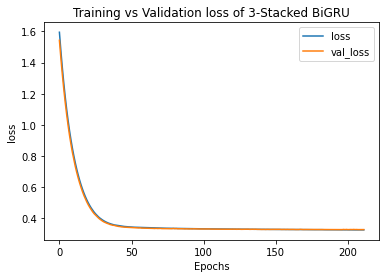

212


In [181]:
with open('./Models/history3StackedBiGRU', "rb") as file_pi:
    load_history3StackedBiGRU = pickle.load(file_pi)

plot_graphs(load_history3StackedBiGRU, "loss", "3-Stacked BiGRU")
print(len(load_history3StackedBiGRU['loss']))

## Prediction

### Prediction with training data

In [182]:
forecast_train_data = model_forecast(model3StackedBiGRU, pm2p5_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(pm2p5_train_scaled.shape[0]-n_lookback)

1009/1009 [==============================] - 5s 4ms/step
(1009, 24)
(1008,)
1008


In [183]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(pm2p5_train), stdev(pm2p5_train.flatten()))
forecast_train_data[:5]

array([37.6322784 , 41.86516185, 45.5840034 , 49.41483493, 51.59532924])

In [184]:
actual = np.squeeze(pm2p5_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1008,)
[62. 74. 87. 82. 68.]


In [185]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2022-04-22 00:00:00    62.0  37.632278
1    2022-04-22 01:00:00    74.0  41.865162
2    2022-04-22 02:00:00    87.0  45.584003
3    2022-04-22 03:00:00    82.0  49.414835
4    2022-04-22 04:00:00    68.0  51.595329
...                  ...     ...        ...
1003 2022-06-02 19:00:00    13.0  15.205770
1004 2022-06-02 20:00:00    13.0  15.157203
1005 2022-06-02 21:00:00    15.0  15.248692
1006 2022-06-02 22:00:00    16.0  15.873801
1007 2022-06-02 23:00:00    14.0  16.729704

[1008 rows x 3 columns]

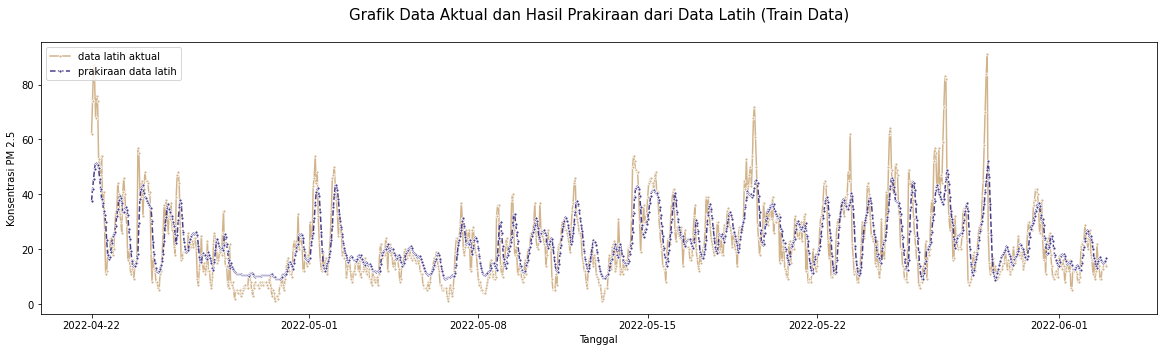

In [186]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [187]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  8.56
MAE:  6.24
MAPE:  0.2838


### Prediction with validation data

In [188]:
forecast_val_data = model_forecast(model3StackedBiGRU, pm2p5_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(pm2p5_val_scaled.shape[0]-n_lookback)

361/361 [==============================] - 2s 4ms/step
(361, 24)
(360,)
360


In [189]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(pm2p5_val), stdev(pm2p5_val.flatten()))
forecast_val_data[:5]

array([38.22600269, 42.17606258, 46.65604591, 50.15857124, 52.86686707])

In [190]:
actual = np.squeeze(pm2p5_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(360,)
[47. 58. 63. 70. 72.]


In [191]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2022-06-04 00:00:00    47.0  38.226003
1   2022-06-04 01:00:00    58.0  42.176063
2   2022-06-04 02:00:00    63.0  46.656046
3   2022-06-04 03:00:00    70.0  50.158571
4   2022-06-04 04:00:00    72.0  52.866867
..                  ...     ...        ...
355 2022-06-18 19:00:00    14.0  21.815139
356 2022-06-18 20:00:00    16.0  22.238095
357 2022-06-18 21:00:00    36.0  23.042641
358 2022-06-18 22:00:00    34.0  29.281927
359 2022-06-18 23:00:00    39.0  34.495097

[360 rows x 3 columns]

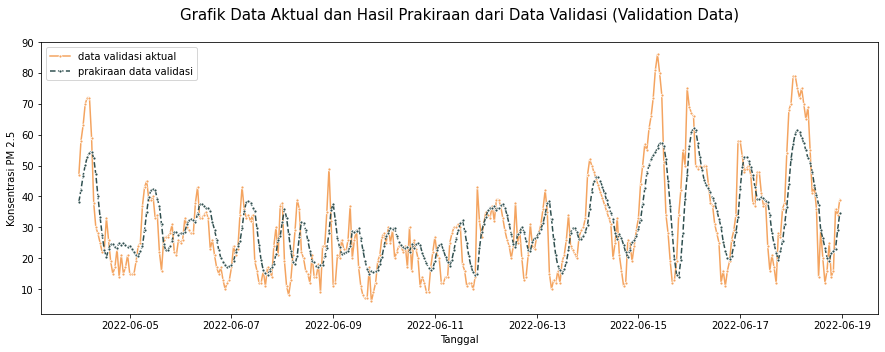

In [192]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [193]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  9.87
MAE:  7.75
MAPE:  0.267


### Prediction with test data

In [194]:
forecast_test_data = model_forecast(model3StackedBiGRU, pm2p5_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(pm2p5_test_scaled.shape[0]-n_lookback)

49/49 [==============================] - 0s 5ms/step
(49, 24)
(48,)
48


In [195]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(pm2p5_test), stdev(pm2p5_test.flatten()))
forecast_test_data[:5]

array([35.90138186, 39.35954441, 44.17063393, 44.82101144, 47.05989064])

In [196]:
actual = np.squeeze(pm2p5_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(48,)
[41. 48. 38. 47. 69.]


In [197]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0  2022-06-20 00:00:00    41.0  35.901382
1  2022-06-20 01:00:00    48.0  39.359544
2  2022-06-20 02:00:00    38.0  44.170634
3  2022-06-20 03:00:00    47.0  44.821011
4  2022-06-20 04:00:00    69.0  47.059891
5  2022-06-20 05:00:00    77.0  53.130596
6  2022-06-20 06:00:00    79.0  58.954549
7  2022-06-20 07:00:00    79.0  62.518803
8  2022-06-20 08:00:00    68.0  64.163627
9  2022-06-20 09:00:00    54.0  63.101584
10 2022-06-20 10:00:00    50.0  59.330729
11 2022-06-20 11:00:00    36.0  54.797451
12 2022-06-20 12:00:00    42.0  47.136806
13 2022-06-20 13:00:00    43.0  42.285247
14 2022-06-20 14:00:00    35.0  39.594759
15 2022-06-20 15:00:00    32.0  36.134095
16 2022-06-20 16:00:00    27.0  33.249594
17 2022-06-20 17:00:00    27.0  30.666442
18 2022-06-20 18:00:00    23.0  29.456936
19 2022-06-20 19:00:00    35.0  28.819449
20 2022-06-20 20:00:00    41.0  31.492983
21 2022-06-20 21:00:00    41.0  36.266228
22 2022-06-20 22:00:00    38.0  40.643577
23 2022-06-20 23:00:00    39.0  43.064055
24 2022-06-21 00:00:00    37.0  44.631694
25 2022-06-21 01:00:00    44.0  44.589174
26 2022-06-21 02:00:00    46.0  45.990656
27 2022-06-21 03:00:00    33.0  47.486457
28 2022-06-21 04:00:00    28.0  44.298689
29 2022-06-21 05:00:00    27.0  39.531959
30 2022-06-21 06:00:00    45.0  35.158393
31 2022-06-21 07:00:00    64.0  36.733640
32 2022-06-21 08:00:00    58.0  43.609711
33 2022-06-21 09:00:00    44.0  49.181606
34 2022-06-21 10:00:00    27.0  50.203190
35 2022-06-21 11:00:00    27.0  45.031867
36 2022-06-21 12:00:00    24.0  39.423758
37 2022-06-21 13:00:00    26.0  34.234060
38 2022-06-21 14:00:00    22.0  30.646891
39 2022-06-21 15:00:00    22.0  28.001608
40 2022-06-21 16:00:00    21.0  26.624566
41 2022-06-21 17:00:00    28.0  26.126772
42 2022-06-21 18:00:00    30.0  27.339160
43 2022-06-21 19:00:00    43.0  29.406039
44 2022-06-21 20:00:00    41.0  35.167832
45 2022-06-21 21:00:00    54.0  39.639951
46 2022-06-21 22:00:00    42.0  46.161165
47 2022-06-21 23:00:00    36.0  47.854338

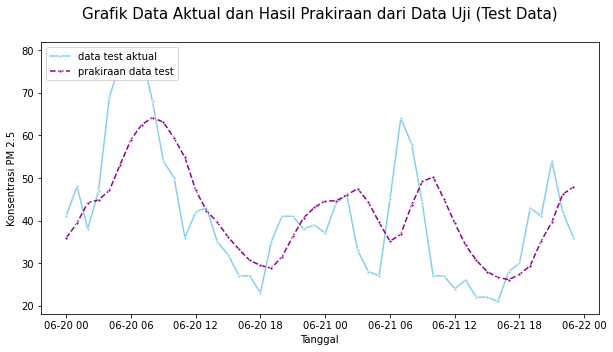

In [198]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [199]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  11.56
MAE:  9.4
MAPE:  0.2249


## Summary Eval Metric

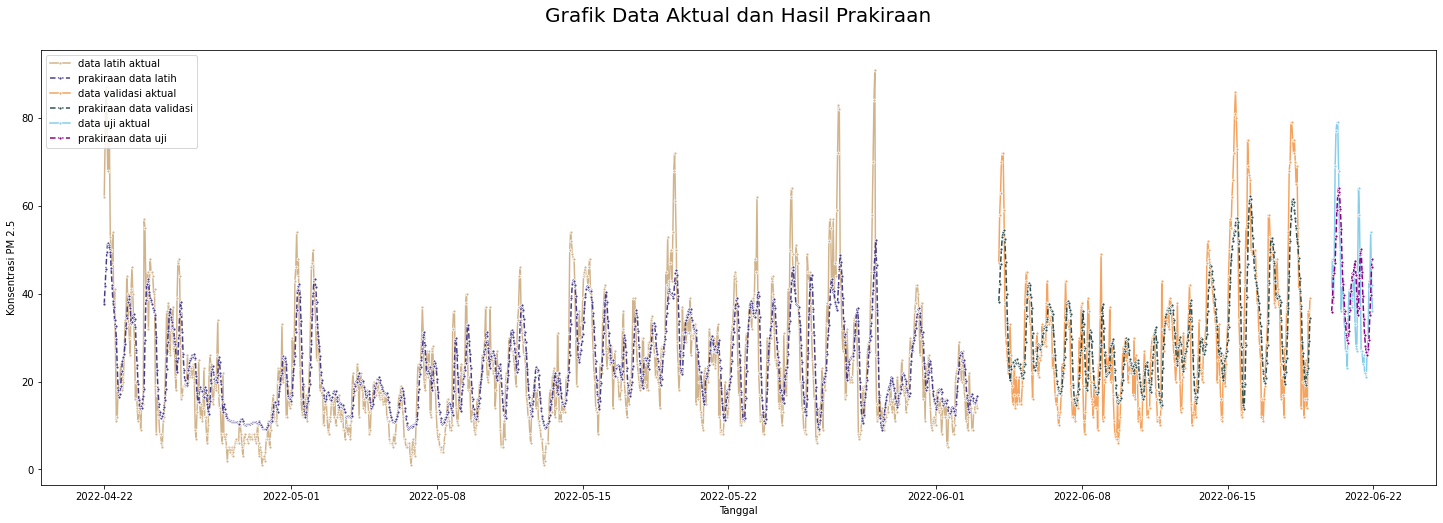

In [200]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

In [201]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  8.56
MAE:  6.24
MAPE:  0.2838
Forecast Val accuracy
RMSE:  9.87
MAE:  7.75
MAPE:  0.267
Forecast Test accuracy
RMSE:  11.56
MAE:  9.4
MAPE:  0.2249


# History Graph

In [202]:
def plot_graphs(history, metric):
    plt.plot(history[metric])
    plt.plot(history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of Vanilla GRU")
    plt.legend([metric, f'val_{metric}'])
    plt.show()

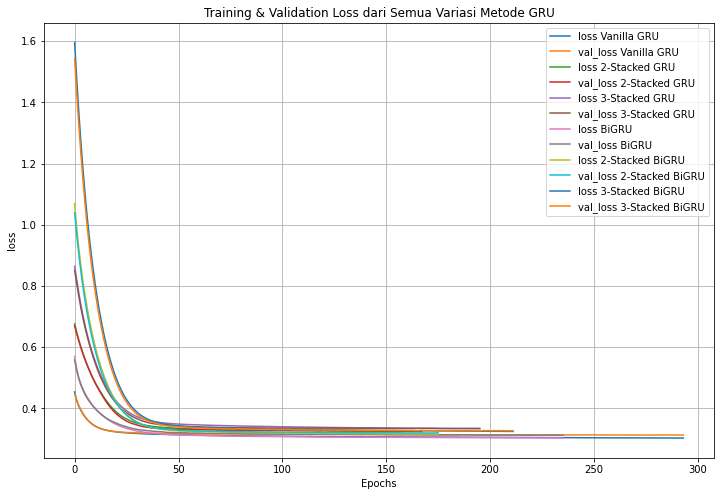

In [203]:
plt.subplots(figsize=(12, 8))
plt.plot(load_historyVanillaGRU["loss"])
plt.plot(load_historyVanillaGRU['val_loss'])
plt.plot(load_history2StackedGRU["loss"])
plt.plot(load_history2StackedGRU['val_loss'])
plt.plot(load_history3StackedGRU["loss"])
plt.plot(load_history3StackedGRU['val_loss'])


plt.plot(load_historyBiGRU["loss"])
plt.plot(load_historyBiGRU['val_loss'])
plt.plot(load_history2StackedBiGRU["loss"])
plt.plot(load_history2StackedBiGRU['val_loss'])
plt.plot(load_history3StackedBiGRU["loss"])
plt.plot(load_history3StackedBiGRU['val_loss'])

plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title(f"Training & Validation Loss dari Semua Variasi Metode GRU")
plt.legend(["loss Vanilla GRU", 'val_loss Vanilla GRU',
            "loss 2-Stacked GRU", 'val_loss 2-Stacked GRU',
            "loss 3-Stacked GRU", 'val_loss 3-Stacked GRU',  
            "loss BiGRU", 'val_loss BiGRU',
            "loss 2-Stacked BiGRU", 'val_loss 2-Stacked BiGRU',
            "loss 3-Stacked BiGRU", 'val_loss 3-Stacked BiGRU', ])
plt.grid()